# SOI1010 Machine Learning II - Assignment #2

The submission should include a code (both link to the colab and .py format) and a report that has answers to the questions and results. Use PyTorch (or TensorFlow/JAX). Also, minimize the use of numpy. There will be mark deductions if numpy is used when PyTorch is preferable or should be used. Marks will be deducted if the submission does not include the requested files. DO NOT use other libraries, such as scikit-learn/sklearn, to use a model (kNN in this case) you are supposed to implement. Using sklearn or any other third library or already built-in functions that you are asked to implement will result in 0 mark. So, please don’t ask “Can I use this library/numpy/etc.?” Also, if an assignment asks you to implement some model, that means you shouldn’t use the built-in implementation from any library for that model in the first place.

### Problem #2 [Bonus/Optional]: Multiclass Classification via soft-margin SVM on CIFAR10

##### a) Perform multiclass classification using soft-margin SVM on the whole dataset.

In [66]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Now using {device}")

Now using mps


In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                            transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                            transform=transform)

traindata, validdata = random_split(trainset, [int(len(trainset)*.9), int(len(trainset)*.1)])
train_loader = DataLoader(traindata, batch_size=64, shuffle=True)
valid_loader = DataLoader(validdata, batch_size=64, shuffle=True)
print(f'''Train Data : {len(traindata)}
Valid Data : {len(validdata)}
''')

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Train Data : 45000
Valid Data : 5000

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]), torch.int64


In [68]:
labels_map = {j:i for (i,j) in trainset.class_to_idx.items()}
labels_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [69]:
#### Hyperparameters ####
bs = 64
epochs = 10
learning_rate = 0.001
gamma = 1

In [70]:
class SVM(nn.Module):
    def __init__(self, gamma=1.0):
        super(SVM, self).__init__()
        self.func = nn.Linear(3072, 10)
        self.gamma = gamma

    def forward(self, x):
        x = x.view(x.size(0), -1)
        fwd = self.func(x)
        return fwd

model = SVM(gamma).to(device)
print(model)

SVM(
  (func): Linear(in_features=3072, out_features=10, bias=True)
)


In [71]:
# Train
def train(dataloader, model, loss_fn, optimizer, epochs):
    hist = []
    for epoch in range(epochs):
        print(f"-------Epoch {epoch+1:2}-------")
        loss_ = 0
        for x, y in tqdm(dataloader, total=len(dataloader)):
            x, y = Variable(x).to(device), Variable(y).to(device)
            
            optimizer.zero_grad()

            yhat = model(x).softmax(dim=1) 
            loss = loss_fn(yhat, y) + torch.norm(model.func.weight) / (2 * model.gamma)
            
            loss.backward()
            optimizer.step()

            loss_ += loss.item()
            
        loss_ /= len(dataloader)
            
        print(f'Average Loss: {loss_}\n')
        hist.append(loss_)
    return hist

In [72]:
# Loss function
def CrossEntropy(yhat, y):
    oh_lbl = torch.nn.functional.one_hot(y, num_classes=yhat.size(1))
    loss = -torch.sum(oh_lbl * torch.log(yhat), dim=1).mean()
    return loss

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

-------Epoch  1-------


100%|██████████| 704/704 [00:06<00:00, 115.73it/s]


Average Loss: 2.2829233035445213

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 2.2347625969824465

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.09it/s]


Average Loss: 2.2378489898348395

-------Epoch  4-------


100%|██████████| 704/704 [00:06<00:00, 106.14it/s]


Average Loss: 2.2370636370033026

-------Epoch  5-------


100%|██████████| 704/704 [00:06<00:00, 115.42it/s]


Average Loss: 2.235409002243118

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 119.51it/s]


Average Loss: 2.2371376161886887

-------Epoch  7-------


100%|██████████| 704/704 [00:06<00:00, 115.00it/s]


Average Loss: 2.2375104034488853

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 118.57it/s]


Average Loss: 2.2388065575876017

-------Epoch  9-------


100%|██████████| 704/704 [00:06<00:00, 115.09it/s]


Average Loss: 2.23271756619215

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 118.95it/s]


Average Loss: 2.236237547614358



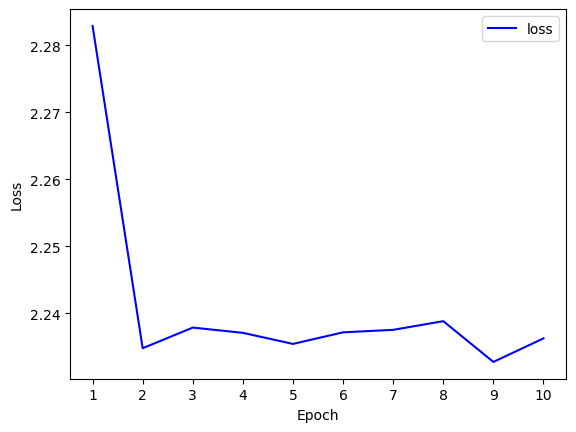

In [73]:
# Train Model
model.train()
hist = train(train_loader, model, CrossEntropy, optimizer, epochs)
plt.plot(range(1, epochs+1), hist, 'b', label='loss')
plt.xticks(range(1, epochs+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig7_multi_loss.png', dpi=200)

In [75]:
classes = list(labels_map.values())
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).softmax(dim=1)
        _, predictions = torch.max(outputs, dim=1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                correct += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:10s} is {accuracy:.2f}% ({correct_count:3}/{total_pred[classname]})')

print()
print(f"Total Accuracy : {100 * correct / len(validdata):.2f}% ({correct}/{len(validdata)})")

Accuracy for class: airplane   is 32.03% (164/512)
Accuracy for class: automobile is 31.82% (161/506)
Accuracy for class: bird       is 25.39% (130/512)
Accuracy for class: cat        is 21.74% (115/529)
Accuracy for class: deer       is 16.24% ( 82/505)
Accuracy for class: dog        is 37.11% (190/512)
Accuracy for class: frog       is 20.08% ( 96/478)
Accuracy for class: horse      is 11.98% ( 55/459)
Accuracy for class: ship       is 54.89% (264/481)
Accuracy for class: truck      is 46.25% (234/506)

Total Accuracy : 29.82% (1491/5000)


In [76]:
def predict(data, model):
    with torch.no_grad():
        model.eval()
        data = data.view(1, -1).to(device)
        yhat = model(data)
        val, ind = torch.max(yhat, dim=1)
        return ind

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


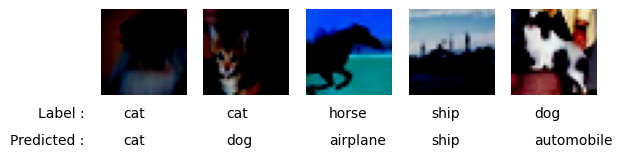

In [77]:
# Predict several data
pick_data = np.random.choice(len(valid_loader), 5, replace=False)
for i in range(5):
    plt.subplot(1,5,i+1)
    
    if i == 0:
        plt.text(-5, 40, "Label : ", horizontalalignment='right')
        plt.text(-5, 50, "Predicted : ", horizontalalignment='right')

    data = validdata[pick_data[i]]
    img = data[0]
    label = data[1]
    pred = predict(img, model).item()
    
    plt.imshow(img.permute(1,2,0))
    plt.text(8,40,labels_map[label])
    plt.text(8,50,labels_map[pred])
    plt.axis('off')

plt.savefig('plot/fig8_multi_predict.png', dpi=200, bbox_inches='tight')

##### b) Perform hyperparameter search.

In [80]:
classes = list(labels_map.values())

def evaluation(model, val_dataloader):
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).softmax(dim=1)
            loss = CrossEntropy(outputs, labels) + torch.norm(model.func.weight) / (2 * model.gamma)

            total_loss += loss.item()
            _, predictions = torch.max(outputs, dim=1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct += 1

    final_acc = correct / len(val_dataloader.dataset)
    final_loss = total_loss / len(val_dataloader)
    return final_acc, final_loss

In [83]:
# Grid Search for optimal hyperparameters
def gridSearch(lr_, gamma_, epoch_):
    lst = []
    for gamma__ in gamma_:
        for lr__ in lr_:
            for epoch__ in epoch_:
                model = SVM(gamma__).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr__)
                
                model.train()
                train(train_loader, model, CrossEntropy, optimizer, epoch__)
                acc, los = evaluation(model, valid_loader)
                lst.append([lr__, gamma__, epoch__, acc, los])
    return lst
                

In [85]:
lr_list = [0.0001, 0.001, 0.01, 0.1]
gamma_list = [0.1, 1.0, 10, 20]
epoch_list = [5, 10, 20, 50, 100]

grid = gridSearch(lr_list, gamma_list, epoch_list)

max_accuracy = max(grid, key=lambda x: x[3])
min_loss = min(grid, key=lambda x: x[4])

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.01it/s]


Average Loss: 3.3312195647846568

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 120.36it/s]


Average Loss: 2.321176887574521

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.46it/s]


Average Loss: 2.3212777738544075

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 2.3216717453165487

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 2.3216423500667918

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 3.3355232514441013

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.90it/s]


Average Loss: 2.320800833742727

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 2.3214182586155157

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 2.3211534947834234

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 120.87it/s]


Average Loss: 2.321279901672493

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 2.3217367411337118

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 2.3216819038445298

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 2.321588170460679

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 2.321693729270588

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 2.321899827569723

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 3.3308519710871307

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.08it/s]


Average Loss: 2.3220564997331663

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 2.321490842171691

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 2.3210129460150544

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.10it/s]


Average Loss: 2.321462520482865

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 2.321700643748045

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 2.3210328526117583

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.58it/s]


Average Loss: 2.320565035736019

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.76it/s]


Average Loss: 2.321461079811508

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.03it/s]


Average Loss: 2.3213707869025795

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.10it/s]


Average Loss: 2.321516687558456

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 2.321251325986602

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.46it/s]


Average Loss: 2.3211581784893167

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 2.32126884162426

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.43it/s]


Average Loss: 2.32100670310584

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: 2.3213413428853857

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 2.3211101561107417

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 120.42it/s]


Average Loss: 2.3211028186435048

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.36it/s]


Average Loss: 2.3219083100557327

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.22it/s]


Average Loss: 2.3218759477815847

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.26it/s]


Average Loss: 3.335408674722368

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 2.3211945078589697

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 120.69it/s]


Average Loss: 2.3216054869646374

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 2.3218754668804733

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.85it/s]


Average Loss: 2.321716574782675

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 120.86it/s]


Average Loss: 2.3216115564785222

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 2.3213313912803475

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 120.73it/s]


Average Loss: 2.321519496427341

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.68it/s]


Average Loss: 2.320992684838447

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 2.321411368521777

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 119.51it/s]


Average Loss: 2.3213339766318146

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 2.321534500542012

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 2.3216792538084765

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.06it/s]


Average Loss: 2.321639259430495

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: 2.320992847396569

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.02it/s]


Average Loss: 2.321599245071411

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 2.3210751468485054

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 2.320987106724219

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.87it/s]


Average Loss: 2.321476100520654

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 2.3209808726202357

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.10it/s]


Average Loss: 2.3210520571605726

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 2.321234527975321

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.321285269138488

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.3213514384220946

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 2.3214707005430353

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.60it/s]


Average Loss: 2.3210915824906393

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: 2.3213212672959673

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 2.3214180161329834

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.53it/s]


Average Loss: 2.3213533352721822

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 2.3210496716201305

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 121.89it/s]


Average Loss: 2.3208509510891004

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 120.92it/s]


Average Loss: 2.3210513784804125

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 2.321756524457173

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 121.23it/s]


Average Loss: 2.3209687806665897

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 2.3214296431026678

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 121.55it/s]


Average Loss: 2.320815995674242

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 121.13it/s]


Average Loss: 2.3214681429619137

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 2.3211439312859015

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 121.51it/s]


Average Loss: 2.3213513876226815

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 2.3211037770591

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 2.321658069775863

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.05it/s]


Average Loss: 2.3215202763676643

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.321281637996435

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 2.3213894075968047

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 2.321370144797997

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 2.321796842258085

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 121.08it/s]


Average Loss: 2.321201145987619

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 2.3215023705905136

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 121.22it/s]


Average Loss: 2.3212971809235485

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 2.32140028713779

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.82it/s]


Average Loss: 3.338344830680977

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 120.39it/s]


Average Loss: 2.3214597637680443

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.15it/s]


Average Loss: 2.321418013762344

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 120.75it/s]


Average Loss: 2.3214910782196303

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 120.65it/s]


Average Loss: 2.321453597396612

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 121.15it/s]


Average Loss: 2.3215085596523504

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.01it/s]


Average Loss: 2.3215050883591175

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.59it/s]


Average Loss: 2.3212516040287237

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 120.87it/s]


Average Loss: 2.3218929984352807

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.07it/s]


Average Loss: 2.3215974572707307

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 2.32137301733548

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 120.64it/s]


Average Loss: 2.321512045846744

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.57it/s]


Average Loss: 2.321404544467276

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 2.320830588313666

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.17it/s]


Average Loss: 2.321316161616282

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 2.321772590279579

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 121.04it/s]


Average Loss: 2.3213515390049326

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.01it/s]


Average Loss: 2.3215760117904707

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.11it/s]


Average Loss: 2.320899802514098

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 120.70it/s]


Average Loss: 2.321685462851416

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 2.321725496514277

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.24it/s]


Average Loss: 2.3214706063947896

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 2.3218059475448998

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 121.29it/s]


Average Loss: 2.321297678419135

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 2.3214323324236004

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 2.321212085133249

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 121.31it/s]


Average Loss: 2.3217632817951115

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 2.321259808133949

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.42it/s]


Average Loss: 2.321615057235414

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 121.12it/s]


Average Loss: 2.3210826316340403

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 2.321712003174153

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 2.3215476789257745

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 121.01it/s]


Average Loss: 2.3211225064640697

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 121.22it/s]


Average Loss: 2.3218042342500254

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 121.23it/s]


Average Loss: 2.321779464117505

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 2.321045509793542

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 120.85it/s]


Average Loss: 2.3210838931528004

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.3215059157122266

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 121.75it/s]


Average Loss: 2.3212133764543315

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 121.14it/s]


Average Loss: 2.321514158086343

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: 2.321468599140644

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 120.36it/s]


Average Loss: 2.321862819181247

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 119.80it/s]


Average Loss: 2.3221675282852217

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 120.26it/s]


Average Loss: 2.321016147394072

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 120.51it/s]


Average Loss: 2.321781897070733

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 2.3208500810644845

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 121.75it/s]


Average Loss: 2.3218471106480467

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 120.73it/s]


Average Loss: 2.321513605727391

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 120.86it/s]


Average Loss: 2.3217432244934817

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 120.71it/s]


Average Loss: 2.321272767402909

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 121.75it/s]


Average Loss: 2.3215001333843577

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 121.63it/s]


Average Loss: 2.321587186306715

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 120.69it/s]


Average Loss: 2.32159507681023

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 2.3214663524519312

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 120.63it/s]


Average Loss: 2.3211212435906585

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.3217641958458857

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 121.38it/s]


Average Loss: 2.321653049100529

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 121.32it/s]


Average Loss: 2.32116617702625

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 121.67it/s]


Average Loss: 2.3213706334883515

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 121.25it/s]


Average Loss: 2.320993548767133

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 2.321064608002251

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 2.32126625593413

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 120.50it/s]


Average Loss: 2.3216658129610797

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 121.37it/s]


Average Loss: 2.3215466751293703

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.3208957334811036

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 121.00it/s]


Average Loss: 2.3218439031730997

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 121.77it/s]


Average Loss: 2.321163467724215

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 121.57it/s]


Average Loss: 2.321144759316336

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 120.99it/s]


Average Loss: 2.321471642364155

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.321925429457968

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 121.56it/s]


Average Loss: 2.3215667940676212

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 121.61it/s]


Average Loss: 2.321238915351304

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 120.55it/s]


Average Loss: 2.3213022527369587

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 2.3210585713386536

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.3213851970027792

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 120.88it/s]


Average Loss: 2.3216787109320816

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 2.32165074382316

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 121.71it/s]


Average Loss: 2.321473039348017

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 121.06it/s]


Average Loss: 2.3215090625665407

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 121.66it/s]


Average Loss: 2.321530443362214

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 120.64it/s]


Average Loss: 2.3214844309470872

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 121.17it/s]


Average Loss: 2.3214623931456697

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 120.92it/s]


Average Loss: 2.3215816105631264

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 2.321518638933247

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 121.46it/s]


Average Loss: 2.3212668607858093

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 120.59it/s]


Average Loss: 2.3215651664544237

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 121.91it/s]


Average Loss: 2.321432901038365

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 120.74it/s]


Average Loss: 2.3213265954770823

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 121.10it/s]


Average Loss: 2.321366771716963

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 121.42it/s]


Average Loss: 2.321237074380571

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 120.70it/s]


Average Loss: 2.321561711755666

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 121.45it/s]


Average Loss: 2.321160999211398

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 120.52it/s]


Average Loss: 2.3215738965029065

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 120.66it/s]


Average Loss: 2.321357562460683

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.32175012068315

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 120.98it/s]


Average Loss: 2.321120720356703

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 121.36it/s]


Average Loss: 2.321421418000351

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.3209426704455507

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 121.11it/s]


Average Loss: 2.3219564231959255

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 121.38it/s]


Average Loss: 2.3214242888445202

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 120.55it/s]


Average Loss: 2.6085895167833026

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.11it/s]


Average Loss: 2.47611718963493

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.60it/s]


Average Loss: 2.480940853668885

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 120.96it/s]


Average Loss: 2.4800354509868403

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.32it/s]


Average Loss: 2.4769014709375123

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 120.51it/s]


Average Loss: 2.6180481406098064

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 2.478981063447215

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 2.477914219891483

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 120.92it/s]


Average Loss: 2.4778144230896775

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 2.474288312210278

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 120.01it/s]


Average Loss: 2.4740610027855094

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.04it/s]


Average Loss: 2.476203777911988

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 2.4766557094725696

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 120.02it/s]


Average Loss: 2.4784457829188216

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.27it/s]


Average Loss: 2.478055340661244

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 120.55it/s]


Average Loss: 2.6106479808010836

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 2.477230826900764

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.37it/s]


Average Loss: 2.4768679138611662

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 120.22it/s]


Average Loss: 2.4789555790749462

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 2.482678535648368

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 119.55it/s]


Average Loss: 2.474397127939896

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.16it/s]


Average Loss: 2.480801510878585

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.475652275776321

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 120.36it/s]


Average Loss: 2.477972236885266

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.02it/s]


Average Loss: 2.4795743481002073

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.4787147282199427

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 120.77it/s]


Average Loss: 2.4767925844273786

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.15it/s]


Average Loss: 2.479137748479843

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.29it/s]


Average Loss: 2.4775707196782935

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 120.65it/s]


Average Loss: 2.476379042660648

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.29it/s]


Average Loss: 2.4800759560682555

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 120.68it/s]


Average Loss: 2.47682923451066

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 2.4754871516065164

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 120.36it/s]


Average Loss: 2.4728928486054595

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.13it/s]


Average Loss: 2.4781982373784888

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 120.82it/s]


Average Loss: 2.6100010089576244

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 120.51it/s]


Average Loss: 2.4712801260704342

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.32it/s]


Average Loss: 2.475943410261111

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.21it/s]


Average Loss: 2.4766081520779566

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 120.85it/s]


Average Loss: 2.474222208627246

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 2.4787666391242635

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.37it/s]


Average Loss: 2.4789507002993063

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 2.4772086018188433

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 120.91it/s]


Average Loss: 2.478739231824875

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.67it/s]


Average Loss: 2.479362941262397

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 121.26it/s]


Average Loss: 2.471681808544831

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 120.91it/s]


Average Loss: 2.477614611387253

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 2.48174507340247

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.02it/s]


Average Loss: 2.4759226918897848

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.45it/s]


Average Loss: 2.4763746725564655

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.63it/s]


Average Loss: 2.4786641939797183

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 120.95it/s]


Average Loss: 2.4712677787650716

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.44it/s]


Average Loss: 2.4810924628241495

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.38it/s]


Average Loss: 2.4745725000446495

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.60it/s]


Average Loss: 2.4746825115924533

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 120.80it/s]


Average Loss: 2.48236911337484

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.16it/s]


Average Loss: 2.481085216795856

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 2.4762502048503268

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 120.38it/s]


Average Loss: 2.470962279899554

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 2.4816563545980235

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.43it/s]


Average Loss: 2.478852528740059

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 120.73it/s]


Average Loss: 2.482086430219087

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 121.53it/s]


Average Loss: 2.4766081547872587

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 120.53it/s]


Average Loss: 2.476882726970044

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 121.30it/s]


Average Loss: 2.4759753942489624

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 2.4759561714123595

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 2.4821923412382603

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 2.4787523106417875

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 2.4753296808762983

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 2.47710691426288

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 2.4772971905767918

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 2.4777766262943093

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 2.4754423566839914

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 2.478247808123177

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 2.478512357243083

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.4793068996884604

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: 2.4828225313262506

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 2.4785330813716757

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 2.4731363091956484

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 2.4802344861355694

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 2.4754683558236468

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 2.479024761779742

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 2.474834109571847

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 2.477735134349628

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 120.05it/s]


Average Loss: 2.472742110490799

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 2.6116313361986117

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 2.479516930200837

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.4783427894792776

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.90it/s]


Average Loss: 2.474969550289891

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.472737467763099

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 2.4802993034774605

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 120.05it/s]


Average Loss: 2.477766465057026

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.66it/s]


Average Loss: 2.48063921589743

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 120.53it/s]


Average Loss: 2.4765252349051563

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.478600320152261

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: 2.4792836904525757

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 119.82it/s]


Average Loss: 2.4698012207042086

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 2.477455873381008

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 2.473977692425251

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 2.477860743010586

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 2.4713293984532356

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.4743337485600603

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.61it/s]


Average Loss: 2.477080235765739

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 2.4769633249803023

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.4754880534654315

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 123.48it/s]


Average Loss: 2.4747475890273396

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.85it/s]


Average Loss: 2.478080940856175

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 2.475456114519726

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 2.477072743868286

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 2.478838847442107

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 2.4740889444947243

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 2.4783265245231716

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 2.4709590057080444

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.89it/s]


Average Loss: 2.4759201393886046

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 2.4703840376301245

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.480854661965912

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.4771268973973664

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 2.4795780317349867

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 2.4766618978570807

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 2.4789915034039454

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.45it/s]


Average Loss: 2.4799784415147523

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 2.4751777682792055

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 2.4742738729850813

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 2.477511052719571

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 121.06it/s]


Average Loss: 2.4740342311561108

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 2.4796318743716586

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.4760733497413723

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 121.68it/s]


Average Loss: 2.4788798449391667

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 2.4781333668665453

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 2.4754930673675104

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 2.4760023071007295

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 121.76it/s]


Average Loss: 2.478838787837462

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 2.480780313299461

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 2.4790257201953367

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 121.34it/s]


Average Loss: 2.4763587293299762

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 2.476100779731165

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.477352673695846

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 2.478300489485264

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 2.4778943332758816

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 121.72it/s]


Average Loss: 2.476045444269072

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.480555808340961

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 2.4771779226985844

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 2.474688319997354

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 2.480610911819068

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 121.70it/s]


Average Loss: 2.477746103636243

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 2.4780311327088964

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 121.71it/s]


Average Loss: 2.477415244010362

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 2.475887853652239

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 2.479499304497784

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 121.85it/s]


Average Loss: 2.4723448187790136

-------Epoch 66-------


100%|██████████| 704/704 [00:06<00:00, 112.69it/s]


Average Loss: 2.4778241616758434

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 123.83it/s]


Average Loss: 2.4807519519870933

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 123.81it/s]


Average Loss: 2.4791009646247733

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 123.66it/s]


Average Loss: 2.4799612306735734

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: 2.471926149319519

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.95it/s]


Average Loss: 2.478003151714802

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 124.31it/s]


Average Loss: 2.4785161546685477

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 123.75it/s]


Average Loss: 2.477392332459038

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 124.56it/s]


Average Loss: 2.4788388972255317

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 2.4765772253952245

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 123.62it/s]


Average Loss: 2.4729934263635767

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 124.01it/s]


Average Loss: 2.4756579040126367

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 123.74it/s]


Average Loss: 2.479212199422446

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 123.91it/s]


Average Loss: 2.4769420390101997

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 124.63it/s]


Average Loss: 2.474719377065247

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 124.36it/s]


Average Loss: 2.477843665602532

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 124.11it/s]


Average Loss: 2.4762676618993282

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.68it/s]


Average Loss: 2.4769159480929375

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 124.18it/s]


Average Loss: 2.48093003440987

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 2.478460493412885

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 121.38it/s]


Average Loss: 2.4742194563150406

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 124.50it/s]


Average Loss: 2.4766463847322897

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 123.69it/s]


Average Loss: 2.480981743132526

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 125.07it/s]


Average Loss: 2.4837589846415953

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 118.68it/s]


Average Loss: 2.479167768223719

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 2.4772917428477244

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 2.4812157946554096

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 2.481325512243943

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 2.478498310866681

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 2.4728945195674896

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 2.4749251546507534

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 2.4750438285144893

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 121.59it/s]


Average Loss: 2.4764175384559413

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 2.4785690615800293

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 2.479990280487321

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 3.8495690785348415

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 3.718999929387461

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.53it/s]


Average Loss: 3.7034837474877182

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 3.7600463777780533

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.72it/s]


Average Loss: 3.7385247749361126

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 3.8512937125157225

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 3.725808773528446

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 3.7148597565564243

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.701507654041052

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.715467402880842

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 3.72405367852612

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 3.690958904271776

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 3.717555336992849

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.7044273845174094

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: 3.7288987182758073

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 3.8230768604712053

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 3.691906587305394

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.740807182070884

-------Epoch  4-------


100%|██████████| 704/704 [00:06<00:00, 108.97it/s]


Average Loss: 3.6893402239815756

-------Epoch  5-------


100%|██████████| 704/704 [00:06<00:00, 107.62it/s]


Average Loss: 3.697183952412822

-------Epoch  6-------


100%|██████████| 704/704 [00:06<00:00, 117.01it/s]


Average Loss: 3.680195005441254

-------Epoch  7-------


100%|██████████| 704/704 [00:06<00:00, 115.19it/s]


Average Loss: 3.687621655111963

-------Epoch  8-------


100%|██████████| 704/704 [00:07<00:00, 95.02it/s] 


Average Loss: 3.70341026478193

-------Epoch  9-------


100%|██████████| 704/704 [00:06<00:00, 103.45it/s]


Average Loss: 3.73975649069656

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 120.77it/s]


Average Loss: 3.717989929020405

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.7071601646867665

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 125.09it/s]


Average Loss: 3.7095364427024666

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 124.57it/s]


Average Loss: 3.6890336143022235

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.48it/s]


Average Loss: 3.717203010550954

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 124.46it/s]


Average Loss: 3.694001008163799

-------Epoch 16-------


100%|██████████| 704/704 [00:06<00:00, 105.69it/s]


Average Loss: 3.750943323089318

-------Epoch 17-------


100%|██████████| 704/704 [00:06<00:00, 105.56it/s]


Average Loss: 3.721750011159615

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.77it/s]


Average Loss: 3.73216406323693

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 3.6897097124972125

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 3.69902106476101

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 3.8707331893118946

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 3.6952797645194964

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.6927897926758635

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 3.6807337443936956

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.7098761075599627

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 3.70851263099096

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 3.7282997451045294

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.736905937167731

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.75it/s]


Average Loss: 3.7209699086167594

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.25it/s]


Average Loss: 3.680134300819852

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.705824492329901

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 3.6858082349327477

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.7189408862455324

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: 3.693447895348072

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 3.7103664560074154

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 3.7551045251840893

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 3.746914175085046

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 3.748290854082866

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.6913632547313515

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 120.12it/s]


Average Loss: 3.684345271777023

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 3.7109116397120734

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 3.669778012755242

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 3.74182270670479

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 3.731070549650626

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 3.7200083573433487

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 3.7433349635790694

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 3.7016157392751086

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 3.702077155086127

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 3.6883722320199013

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 3.7468605776402084

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.7224660214375365

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 3.6973861889405684

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.7313543591987

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.7269126911732284

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 3.7302059304307806

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.74it/s]


Average Loss: 3.7186120077967644

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 3.753748308867216

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 3.7159822959114206

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.39it/s]


Average Loss: 3.7120435271750796

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 121.49it/s]


Average Loss: 3.71855663406578

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.7198332537981598

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 3.724893546917222

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 3.7260822860354725

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.701139355247671

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.689962814477357

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 3.7055174874311145

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.7413284094496206

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 3.7288578023964707

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 3.7000104453076017

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.738892685283314

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 3.828568559139967

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.728658449920741

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.55it/s]


Average Loss: 3.7380853234366938

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 3.706797856498848

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.6943968426097524

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: 3.719867670739239

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.719545791772279

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: 3.749187657778913

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 120.63it/s]


Average Loss: 3.6949086541479286

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.712858147580515

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.6923543831164185

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.7104362445798786

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 3.7043915563686327

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 3.739353546703404

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 120.21it/s]


Average Loss: 3.7143533253534273

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 3.6989096643572505

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.7546928098255936

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.90it/s]


Average Loss: 3.7068729661405087

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 3.7133794890886005

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 3.714359138499607

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 3.7161475982178342

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: 3.725274709138003

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 3.732746274633841

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 3.714448779482733

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.7335218573835762

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.7341212569312616

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 3.6887563538144934

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 3.7325903231447395

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.78it/s]


Average Loss: 3.71329122104428

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 3.706933591514826

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.685419998724352

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 3.73804024098949

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 3.7240657958794725

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: 3.7005653780969707

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: 3.723664456470446

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.35it/s]


Average Loss: 3.67408321459185

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 123.48it/s]


Average Loss: 3.73615919967944

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 3.6848815205422314

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 3.6928117607127535

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 3.7578943127935585

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.94it/s]


Average Loss: 3.6711131605235012

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 3.718084430830045

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 3.7298200435259123

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 123.59it/s]


Average Loss: 3.700559501620856

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: 3.696872991933064

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: 3.704624506221576

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 123.71it/s]


Average Loss: 3.718382470648397

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 3.7104752832515673

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 121.56it/s]


Average Loss: 3.760573338039897

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.694049563597549

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 3.756644883616404

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 3.731721207160841

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: 3.6981508931653067

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 3.721720192920078

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 3.7224457561969757

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 3.7181155786595563

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.7019140425730837

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.6684788885441693

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: 3.6893353082916955

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.7015372328460217

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.6880607157945633

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 3.7058643360029566

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.737970954315229

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 3.707789286293767

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 3.7123559083450925

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 3.700101637366143

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 3.73767568746751

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 3.7173016748645087

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.6964754408056084

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 3.738418761640787

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: 3.743221767585386

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 3.708134885877371

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.735265651209788

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 123.53it/s]


Average Loss: 3.721161276440729

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: 3.7227576161650093

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 3.732865360988812

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 3.7183548689565877

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 3.77597752078013

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.7088000486520203

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 3.7209844467314808

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.705583337017081

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.6851970069110394

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 3.733890561894937

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.6909879446029663

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.7184579084542664

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 123.62it/s]


Average Loss: 3.6894155591726303

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 3.689815233376893

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.695989902046594

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 123.39it/s]


Average Loss: 3.7274926917796787

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.7360184734517876

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 3.723468913273378

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 3.713403744453734

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 121.21it/s]


Average Loss: 3.687175241383639

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 3.6961993802000177

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: 3.7569662105630743

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 3.735735230825164

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.7080664699050514

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 3.6934271800247105

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 3.7417485040019858

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: 3.724188705059615

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.33it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.70it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.31it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.62it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.32it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.44it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.19it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.66it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.47it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 123.75it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 124.12it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.82it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.19it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.85it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.63it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.73it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.49it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 121.47it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.89it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: nan

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: nan

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: nan

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: nan

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: nan

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: nan

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: nan

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: nan

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: nan

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: nan

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: nan

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: nan

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 121.72it/s]


Average Loss: nan

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 121.05it/s]


Average Loss: nan

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: nan

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: nan

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: nan

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: nan

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: nan

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 121.91it/s]


Average Loss: nan

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: nan

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: nan

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: nan

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: nan

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 121.70it/s]


Average Loss: nan

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: nan

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: nan

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 121.59it/s]


Average Loss: nan

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: nan

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 123.32it/s]


Average Loss: nan

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: nan

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: nan

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: nan

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: nan

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: nan

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: nan

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: nan

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 120.58it/s]


Average Loss: nan

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: nan

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: nan

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: nan

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 2.476647423072295

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 2.125401683490385

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 2.1178132112730634

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 2.116503565656868

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 2.115591983903538

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 2.481322689997879

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 2.126379432664676

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 2.1175146839496763

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 2.118524361232465

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 2.115531098605557

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 2.1147238061848013

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 2.1151091095737438

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 2.114826810969548

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 2.1137635501270946

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 2.112997783178633

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 2.4762758500874043

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 2.126556448977102

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 2.1171949216249315

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.117248943752863

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 2.1156237602911214

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 2.114693409170617

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 2.1157088725065645

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 2.113806628029455

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 2.1139311483976515

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.80it/s]


Average Loss: 2.1132498361508953

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 2.1137676504863934

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 120.77it/s]


Average Loss: 2.1133585174314002

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 2.1136010004715486

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 2.112872678786516

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 2.112313214012168

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 2.1129482336003673

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.63it/s]


Average Loss: 2.113159790635109

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 2.11228148131208

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 2.112605167214166

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 2.112586187198758

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 2.472970275039023

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 2.1252898289398714

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 2.117505573074926

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 2.1179851340976628

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 2.115926478566094

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 2.114947021854195

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.53it/s]


Average Loss: 2.1143536032600836

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 2.1141840747811576

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 2.11407443288375

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 2.1133606149391695

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 2.1129043816842814

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 2.112782196565108

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 2.1128980334509504

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 2.1124412153254855

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.04it/s]


Average Loss: 2.1126110812818464

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.64it/s]


Average Loss: 2.1130996153435926

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 2.1124436933208597

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 2.1120608643713323

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 2.1125828816809435

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.1113719714974817

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 2.112620858136903

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 2.1118794315579263

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 2.11205729232593

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 2.112001225182956

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 2.1122527308762074

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 2.1118670834059063

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 2.11212776533582

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 2.1119587269018996

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.49it/s]


Average Loss: 2.1116764298216864

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 121.38it/s]


Average Loss: 2.1126279753040182

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 2.1114821051332084

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 2.1109380217438396

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 2.1126355588097465

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 2.1123459577899086

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 2.1114376366815786

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 2.1130748565562745

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 2.1117073807188054

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 120.07it/s]


Average Loss: 2.1105462299151854

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 121.55it/s]


Average Loss: 2.1120790441266517

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 121.52it/s]


Average Loss: 2.112165441397916

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 120.67it/s]


Average Loss: 2.111832718280229

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 2.1117474878714844

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 121.34it/s]


Average Loss: 2.1120855318890377

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 2.1123215435919436

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 121.42it/s]


Average Loss: 2.11138207313012

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 121.21it/s]


Average Loss: 2.111640718172897

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 2.1122095926918765

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: 2.1119747295637024

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 2.1121335947378115

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 2.111301975832744

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 2.4784388936717403

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 2.1269471906125546

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: 2.1174550274894997

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 2.117613582109863

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 2.114765119654211

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 2.1151128988713026

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 2.1152281227775593

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 2.114434926008636

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 2.1133918660608204

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 2.1132891206917437

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: 2.112958832389929

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.114016641100699

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 2.1129777274009856

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 2.11285340633582

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.66it/s]


Average Loss: 2.113554199649529

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.80it/s]


Average Loss: 2.112225312908942

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 2.11261178502305

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 2.1121560780500825

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 2.1122025811875407

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.113514227961952

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 2.111559744924307

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: 2.112161096354777

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 2.112870022485202

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 2.1119864899665117

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 2.113069811835885

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.77it/s]


Average Loss: 2.1118608946827324

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 2.111332102424719

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 2.11248302730647

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 2.1111298755488614

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 2.1121042497794735

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 2.111573814499107

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 2.1121408353475006

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 2.1115362120961603

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.73it/s]


Average Loss: 2.111632612110539

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 2.1120094909248026

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 2.1117197945713997

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 2.1124554359438745

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 2.112146105278622

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.1113310253078286

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: 2.111696520312266

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 2.112865456125953

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 2.111497898332097

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 2.1112962168726055

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 2.1117534840648826

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 2.1126492114906963

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 2.1121551910923286

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 118.97it/s]


Average Loss: 2.1130783154883166

-------Epoch 48-------


100%|██████████| 704/704 [00:06<00:00, 113.31it/s]


Average Loss: 2.111599113284187

-------Epoch 49-------


100%|██████████| 704/704 [00:06<00:00, 116.52it/s]


Average Loss: 2.1116752519526263

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 2.1119725052267313

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 2.1125417722558435

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 2.1115583939985796

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 2.111383890902454

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 2.1124785249544815

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.112617955797098

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 121.68it/s]


Average Loss: 2.111988930878314

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.24it/s]


Average Loss: 2.1119428033178504

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 2.111067748543891

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 2.1118568031286653

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 2.110816426575184

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 2.1121723506261003

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.111991401592439

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 2.1117452869022433

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 2.11229823495854

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 2.111551922661337

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 2.1117876912043854

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 121.49it/s]


Average Loss: 2.112549206580628

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 121.63it/s]


Average Loss: 2.112291258167137

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 121.75it/s]


Average Loss: 2.112583887509324

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 2.1113960466940296

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 2.1130418106913567

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.1123998654498295

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 2.112534312870015

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 2.11198204129257

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 2.1123325836590747

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 121.30it/s]


Average Loss: 2.111247166652571

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 2.1113992304625837

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 123.32it/s]


Average Loss: 2.1127157649871977

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 2.1123138667846266

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 2.1112372519617733

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 2.112478975883939

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 2.112324454059655

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: 2.112234355373816

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 2.111915274777196

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 2.1114838614382525

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.1116081415252252

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 2.1121489720588382

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 2.111644762822173

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 2.1123350602997975

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 2.1115445374426516

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 119.67it/s]


Average Loss: 2.111895365132527

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 2.1124151194976135

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 2.11173865808682

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 121.17it/s]


Average Loss: 2.111940885978666

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 123.78it/s]


Average Loss: 2.1113669472661885

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: 2.111869695850394

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 2.112250878052278

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 2.1120458263903856

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: 2.111535056240179

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 2.1119801219214094

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 120.64it/s]


Average Loss: 2.282794266769832

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: 2.240527483549985

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 2.234942151910879

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 2.237106755375862

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.80it/s]


Average Loss: 2.234730651263486

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 2.286821122027256

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 2.2395011386410757

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 2.2335848843848165

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.2388782528313724

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 2.23637196269225

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.23222741230645

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: 2.2347101269459184

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 2.2379129688170822

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 2.2399684056978333

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.19it/s]


Average Loss: 2.2381880176676945

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 2.282771102406762

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 2.235787541351535

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 2.2378114189275284

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 2.234619691290639

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 2.2384930762716313

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 2.2410800726237623

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.62it/s]


Average Loss: 2.2365972420031373

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 2.234187389808622

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.2369978830895643

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.238444089720195

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 2.240607022900473

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 2.2379201223904435

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 2.2345873950557276

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 2.2344675839624624

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 2.2400001776828007

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 2.2366129363125022

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 2.2350079486654564

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 2.237718988717957

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 2.238771507855166

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 2.2386884648691523

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: 2.285253111611713

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 2.2334244180132043

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 2.2364784208211033

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 2.2324826473539527

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 2.238938234069131

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 2.2348705636845394

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.241249892013994

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.90it/s]


Average Loss: 2.2349582575261593

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 2.2377938878807155

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.64it/s]


Average Loss: 2.232399216937748

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 2.233263038437475

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 2.2343228127468717

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 2.238357770002701

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 2.2379375504837795

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 2.2394250881942837

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 2.23525039665401

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 2.2344545913352207

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 2.242540677670728

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 2.2399824173613028

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 2.2325379250740465

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 2.2369973508810457

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.2325185298581016

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 2.2368598688732493

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 2.2397618239576165

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 2.2394642934880475

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 2.238559552045031

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 2.2414366702803155

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 2.2385658086700873

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 2.2316738980060276

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: 2.23647058585828

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 2.236563637514006

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 123.46it/s]


Average Loss: 2.238524215295911

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.234419524161653

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 2.235220290720463

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 2.235864035277204

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 121.59it/s]


Average Loss: 2.235320652581074

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 2.2377197871154006

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.92it/s]


Average Loss: 2.2393164575438607

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 2.2342282689430495

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 2.233456404710358

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 2.2393329802223225

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 2.236892403188077

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 2.2375146221708166

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 2.243594840338284

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.66it/s]


Average Loss: 2.237952211871743

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 2.237318408929489

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 2.234193215315992

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.88it/s]


Average Loss: 2.2341881646690043

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 2.2340620522471992

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: 2.237714124843478

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.281171204860915

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 2.235175558111884

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 2.238875511525707

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 2.2362941542470995

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.51it/s]


Average Loss: 2.235955588011579

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 2.2387885837392374

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 2.235019830817526

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: 2.236184572462331

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 2.2364203464239836

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 2.234783138571815

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.237811468033628

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 2.2332161654802887

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 2.2360719069838524

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 2.2328595867888494

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 2.232314384119077

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 2.2320109368725256

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 2.2340200909159402

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 2.235673190348528

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 2.2376253212040123

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.95it/s]


Average Loss: 2.237429824403741

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 2.242112562060356

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: 2.236566302281889

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 2.24022763713517

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 2.2354176566004753

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 123.44it/s]


Average Loss: 2.240991338071498

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 2.237831210717559

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 2.236273193731904

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 2.236950070173903

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 2.240376104177399

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: 2.2383627141402527

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 2.2396501656621695

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 123.49it/s]


Average Loss: 2.2361615945331077

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.55it/s]


Average Loss: 2.2335613651031796

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 2.2336303398690442

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 2.236913337287578

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.238070599565452

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 2.2406823543662373

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 2.2356475203890693

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 2.2307373336092993

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: 2.239045607603409

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.61it/s]


Average Loss: 2.2333477903157473

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 2.2364869436079804

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: 2.2368026047267695

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 2.2371373840353708

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 2.2332641162316906

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 2.238029506734826

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 2.2413078009743583

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 2.23760112866082

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 2.2362526650117203

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: 2.235860285095193

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 2.2328145922246305

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 2.238668347962878

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 2.237961043688384

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 2.232737150043249

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 2.2375585059212013

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 2.2349023234776477

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 2.2379031853581015

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 2.238651553846218

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 2.2333516393872825

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 2.23674745044925

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 2.243079499256882

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 2.2371271276338534

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.235281360081651

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 2.234985448081385

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 2.2435308625413612

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 2.240337145599452

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.23110417666083

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 2.238708653233268

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 2.237609153105454

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 2.238096062093973

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 2.233328075740825

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 2.240537168458104

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 123.45it/s]


Average Loss: 2.238869269463149

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 2.2378994404253634

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 2.2374340170486406

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 2.2352743545039133

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 2.238683611493219

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 2.2346263373778625

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 2.2399492380632595

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 2.2392872790382667

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 2.2332973537797276

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 123.32it/s]


Average Loss: 2.236875923181122

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 2.235539526593956

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 2.2412089436230334

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 120.50it/s]


Average Loss: 2.2409111317247152

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 2.233073144981807

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 2.2466175400397996

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 2.2414829495616932

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 121.47it/s]


Average Loss: 2.2365260637280615

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.2337506999346344

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 2.235921345820481

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.2372412994842636

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 2.2366821093654092

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 2.2386903642592104

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 123.33it/s]


Average Loss: 2.2362576475874945

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 2.235284628177231

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 2.237981989641081

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 2.238186262717301

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 2.234788579696959

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 2.2359665254638954

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 3.655821142210202

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 3.698044534095309

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 3.7061828784644604

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 3.6991016942669046

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.5655886473303493

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 3.613739970732819

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.6585801656950605

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 3.6162462024526163

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.62it/s]


Average Loss: 3.7346968257969078

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 3.6309220861982214

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 3.657412689517845

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.18it/s]


Average Loss: 3.687542351470752

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.640229617668824

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.622657510367307

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 3.6160280281169848

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.711713679812171

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.6814792921597306

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 3.638376457786018

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 3.6299408569254656

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 3.6238513331521642

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.6368332623758097

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 3.6734234507788313

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 3.6382038081911476

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.580424618314613

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 3.643289741128683

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 3.597601071000099

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.5940255265344274

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 3.612829653376883

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.587332843379541

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 3.7114195254716007

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 3.5686400227925996

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.675003976307132

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.705622546036135

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 3.668711334466934

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 3.6824843886901033

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 3.690858857536858

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 3.652297965843569

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: 3.6230817301706835

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 3.641474777663296

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 3.6641876558688553

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: 3.5885957774113524

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 3.638501378622922

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 3.60160587050698

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.6755076457153666

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.616577122360468

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 3.6054803989827633

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 3.6323637281629173

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.7035250789062544

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 3.6469163860787046

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 3.6462232629683884

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 3.6826765974136917

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 3.630006136203354

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.644818748940121

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: 3.7273957627740772

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 3.6188892759382725

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 3.686824203214862

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.613181308589198

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.55it/s]


Average Loss: 3.6248440383510157

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.578043702651154

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.649771536615762

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 3.6477267115630885

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.652540421282703

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 3.6186021894893865

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.6304170956665818

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.6247609000314367

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 121.82it/s]


Average Loss: 3.6776171157305892

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.6755447658625515

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 3.6327239332551304

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 3.629912231117487

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 3.6524617699059574

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 3.613790651275353

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 3.577790106562051

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 3.6486606316810306

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 3.6050028157505123

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.6657694926993414

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 3.663172289051793

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.651780151508071

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 3.656381291421977

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 3.61703047901392

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 3.6434558128768746

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.6355197700587185

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 3.581360184672204

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 3.620179094035517

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 3.656913098963824

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.40it/s]


Average Loss: 3.644452463835478

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: 3.6778275214812974

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 3.678119010207328

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.6553876650604336

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 3.622191771526228

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 3.6010787297378886

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 3.5898326692933384

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.658722638406537

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.35it/s]


Average Loss: 3.622522968460213

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.98it/s]


Average Loss: 3.639564523304051

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.631847770376639

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.6661080047488213

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 3.599544961344112

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.7101560086011887

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.76it/s]


Average Loss: 3.576556011357091

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.26it/s]


Average Loss: 3.6146131235767496

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 3.6710722632706165

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.7189691615375606

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 3.6165196262300014

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 3.607716170901602

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 3.668119514530355

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 3.6722455227916893

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.675920506092635

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 3.5727331319993194

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.6745195382020692

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.670309713618322

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: 3.683954170820388

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 3.6512745899910275

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.6715273765677754

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.15it/s]


Average Loss: 3.618049259212884

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: 3.703497100621462

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: 3.6289559230208397

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.6137607026506555

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 3.5518309748308226

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 120.49it/s]


Average Loss: 3.704793348231099

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 3.584533831951293

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 3.6653760834173723

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 3.6995911611752077

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 3.623843499205329

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.62698033452034

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 3.601887334476818

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.7659820941361515

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 123.78it/s]


Average Loss: 3.595847035334869

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 3.6950732257894496

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: 3.6187862032516436

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 3.612374842844226

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.6426206109198658

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.697184383191846

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.35it/s]


Average Loss: 3.676267936148427

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: 3.638756502758373

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 3.6566120250658556

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.658636977726763

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 3.661709725856781

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 3.6476414681158285

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 3.708506715229966

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.6107535043900665

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 3.717011293565685

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 3.608877667649226

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.6935610859231516

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 121.82it/s]


Average Loss: 3.6241279752417044

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 3.6973423686894504

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 3.664766114205122

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: 3.682684750380841

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 123.81it/s]


Average Loss: 3.621952396902171

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 3.660671004517512

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: 3.6765017682178454

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 3.6282247094945475

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 3.648249331184409

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 3.6330418302254244

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 3.604674117808992

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 3.6465753950178623

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 3.6719670939174565

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.6206263429061933

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 3.6590616581114856

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 3.6114760349419983

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 3.670288008383729

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 3.6369158581576566

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 3.6070419004694982

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 3.6827355420047585

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 3.608723906969482

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.6479590802707453

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 3.6604263636876238

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.6561285348778423

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.592446640811183

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 3.6383804838088425

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 123.92it/s]


Average Loss: 3.6459093774584206

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 121.61it/s]


Average Loss: 3.6300943947651167

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.6145860491828485

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.621605687182058

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 3.662900334732099

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 3.6330580711364746

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.639549571343444

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.693931667303497

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.6182436523112385

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: 3.6492258323864504

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 3.6060822507874533

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 121.72it/s]


Average Loss: 3.7147578464990314

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 123.47it/s]


Average Loss: 3.6050998490642416

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.674659614874558

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 3.6133445142344995

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 123.59it/s]


Average Loss: 3.631865455345674

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.66it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.47it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 121.65it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.34it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.73it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 121.22it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 119.67it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 120.57it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 121.49it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 121.70it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 121.18it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 120.18it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 121.49it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 123.52it/s]


Average Loss: nan

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: nan

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: nan

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 123.45it/s]


Average Loss: nan

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: nan

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: nan

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: nan

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: nan

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: nan

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 123.71it/s]


Average Loss: nan

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 121.80it/s]


Average Loss: nan

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: nan

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: nan

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 121.98it/s]


Average Loss: nan

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: nan

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: nan

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.10it/s]


Average Loss: nan

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: nan

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: nan

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: nan

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: nan

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: nan

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: nan

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: nan

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: nan

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 120.12it/s]


Average Loss: nan

-------Epoch 83-------


100%|██████████| 704/704 [00:07<00:00, 97.61it/s] 


Average Loss: nan

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 120.81it/s]


Average Loss: nan

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.10it/s]


Average Loss: nan

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: nan

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: nan

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: nan

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 92-------


100%|██████████| 704/704 [00:06<00:00, 115.93it/s]


Average Loss: nan

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 121.24it/s]


Average Loss: nan

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: nan

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: nan

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: nan

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 120.21it/s]


Average Loss: nan

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 121.58it/s]


Average Loss: nan

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 1.9723902116106315

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 1.8771894230422648

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: 1.8505551024255427

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.8355972214855931

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.8251388900997965

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 1.972225646403703

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 120.55it/s]


Average Loss: 1.8770538316192953

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: 1.8493548858572135

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 1.834506374529817

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 120.95it/s]


Average Loss: 1.82399158552289

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 1.8172840169546278

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 1.8115800812163136

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 1.8053900155831466

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 1.8032956147058443

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.43it/s]


Average Loss: 1.800076620314609

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 1.9724628610367125

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 1.8773859710517256

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 1.8511693425137887

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 1.835454021665183

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: 1.8241453727876598

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 1.8166191510178826

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 1.8117336791686036

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.8064503996548327

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.48it/s]


Average Loss: 1.8035320414399558

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.36it/s]


Average Loss: 1.8000499954955145

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 1.7991775191304358

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 121.42it/s]


Average Loss: 1.796301513232968

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 1.7948750208385966

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 1.7939611736007712

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 1.7921348070217804

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 117.52it/s]


Average Loss: 1.7922626554288648

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.792380067096515

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 1.7904355326159433

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.63it/s]


Average Loss: 1.7898903589018367

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.17it/s]


Average Loss: 1.7899948725984856

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: 1.9720019034364007

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.8782963996583766

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.44it/s]


Average Loss: 1.8509146432307633

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.8352019856260582

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 1.8240082942965357

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 1.816638652404601

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.31it/s]


Average Loss: 1.8111313136125153

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.44it/s]


Average Loss: 1.8058351623741062

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 1.8025444576686078

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 1.7996246699582448

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.7978134343231267

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 124.62it/s]


Average Loss: 1.7962879922918298

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 1.7957537595859983

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 1.79342939755456

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.7930936486544935

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 1.7916949181394144

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.7902330287139525

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 1.7909745023670522

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: 1.790223040194674

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 1.7896676520732315

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.7879345752298832

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.95it/s]


Average Loss: 1.7898756692355329

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 1.7886840704489837

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.7890152932906693

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 123.31it/s]


Average Loss: 1.7892533930187875

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.7877649216150695

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 1.7876655728640882

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 1.7883820911361412

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: 1.7874382923949848

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.7873711724850265

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.787979347969998

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 1.788005075163462

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 1.7867865088311108

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 1.7865210285579616

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 1.7869270471009342

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 1.7877808485857465

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.7875881674276157

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: 1.7878059846433727

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.24it/s]


Average Loss: 1.7875178960913962

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 1.7870701422745532

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: 1.7865167114544998

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 1.7870554956184193

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 1.787460887635296

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 1.785847336392511

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 1.7875575191256674

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.7870881469412283

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 1.7861466841264204

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 1.7875690453431823

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 1.7871855170550672

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.26it/s]


Average Loss: 1.7872620372270995

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 1.9742693796076558

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.84it/s]


Average Loss: 1.8778902282091705

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 1.8498173081739382

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 1.8355134783143348

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 1.8248231947760691

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 1.8166095384142615

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.35it/s]


Average Loss: 1.8111712072383275

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 1.8076335882598704

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.72it/s]


Average Loss: 1.803647605702281

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.72it/s]


Average Loss: 1.8006030099297112

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 1.797154274853793

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.7960552165115422

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.795403397896073

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.7939052515747873

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.792510723695159

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 118.87it/s]


Average Loss: 1.7919143920933658

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 1.7910166773945093

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 1.7912953851575202

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 1.7897411376576533

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 1.7892324475740844

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 1.7898719800128178

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.26it/s]


Average Loss: 1.7892936071888967

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.789810398593545

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.787827256050977

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.7888974454253912

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 1.7883206566965038

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 120.69it/s]


Average Loss: 1.7884462983770804

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.7880577846345576

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 1.788319948383353

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.7877115852792154

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: 1.7874556835740805

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: 1.7879910321736878

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.7877627096392892

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 1.787270163609223

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.7881158160215074

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.7867939429865642

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.7876121418719941

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.84it/s]


Average Loss: 1.7881359708580105

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.7870000998743556

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 121.40it/s]


Average Loss: 1.787601137533784

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: 1.7868994179774413

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 1.7877895732156255

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 1.7874689283357426

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 1.7863204729827968

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.787635893306949

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.7873673965646462

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.7864658805457028

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 1.7883226842704145

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 121.70it/s]


Average Loss: 1.7876454867761244

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.72it/s]


Average Loss: 1.7865889301015572

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: 1.786722748794339

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 1.7869776187633926

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.7874520553106612

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.7871415085074576

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 1.7872318684716115

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 121.56it/s]


Average Loss: 1.7876791263168508

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 1.7869759364561602

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 1.7871877371587537

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 1.7863480579108

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 119.78it/s]


Average Loss: 1.786172597923062

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 1.7872854701497338

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 1.7868888796391813

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 1.7873910579153083

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 1.7863995371894403

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 120.80it/s]


Average Loss: 1.787827272306789

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 1.7873639325526627

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.787621422586116

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 1.7866153071888469

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 120.35it/s]


Average Loss: 1.7872576700015501

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 1.786353224041787

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 1.7862629915841601

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 121.41it/s]


Average Loss: 1.7864362871782347

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 1.7866801575503566

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 1.7859071667560122

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.7869743633676658

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 1.7873849496245384

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: 1.7871384285390377

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 1.7873794580386444

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 1.7880685009400954

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.7874793276529422

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 1.78740321082825

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.7876543340019204

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 1.7868190336633811

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 1.7867419309914112

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.787757628343322

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.7871617720547048

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 1.7868641528554938

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 123.34it/s]


Average Loss: 1.78689351237633

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 121.82it/s]


Average Loss: 1.7873703671449965

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 1.7871618360619654

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 1.7868772950023413

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 1.7869521010328422

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 1.786172344264659

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 1.7875645438378507

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.787135891447013

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.7865339082411744

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 1.78792543082752

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 1.7869310075925156

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 1.7877937480807304

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.7876294001259587

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.9648449798537926

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.9227937107736415

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.9104340027340434

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.9164196442474017

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.9103032137182625

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 1.9620921897955916

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 1.9162916134704242

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.9172371978109533

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 1.9141652971844783

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 1.9117391322824089

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.9114143584262242

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.9132599231194367

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 1.9175750277936459

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.9171687510203232

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: 1.9120899860493161

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 1.9645059504969553

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: 1.9170984253287315

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 1.9129391507330267

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: 1.9141074529087

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 1.9185686074197292

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.9107472227716988

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 1.9163416134701534

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.9137082712894136

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 1.9097110695120962

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 1.917633929374543

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 1.9126526156271046

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 1.9135026999495246

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.47it/s]


Average Loss: 1.9083660707216372

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 1.9127445005896417

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.9096604186025532

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 1.9109540925445883

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 1.9084541386162692

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.49it/s]


Average Loss: 1.9191993434320798

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 120.96it/s]


Average Loss: 1.9131540881300515

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.9136113546450029

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.9693916815925727

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.9190631991421634

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 1.9138871548189358

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.9125691625204952

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.9151773711835796

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 1.9118829545649616

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 1.9143189594826915

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.45it/s]


Average Loss: 1.9102813604880462

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 1.9117913009090857

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 1.9133386486633257

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.9110116953538223

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 1.9123177066106687

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 1.9128800776194443

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 1.9143661558628082

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 120.79it/s]


Average Loss: 1.9151809022507884

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.9092267584055662

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 1.91165688295256

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 1.9132670169188217

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 1.914441242814064

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: 1.9108263856985352

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 1.9138922903009437

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 1.9163322492756627

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.909635440023108

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 1.9125608205795288

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 1.9130703884769569

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 1.9125992948697372

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.910509642721577

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 1.914556284519759

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.9149046763777733

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: 1.9119159215214578

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 1.913022343069315

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 1.914800020273436

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 1.9106419281187383

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 1.9098298586905003

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 1.9154015843841163

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.9142670954831622

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 1.9127289806915955

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 1.9145923839374022

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 1.9149751663208008

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 1.9165605746886947

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 1.9151757261292501

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: 1.9104723559523171

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.9102178944105452

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 121.76it/s]


Average Loss: 1.915296558798714

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.9113025208088485

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 1.9087127491154454

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 1.9134172873402184

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 1.9145924137397246

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 1.9165833763439546

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 1.912003126164729

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.9719557167792863

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 1.9167451457205145

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 1.9123213179409504

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 1.9187358534810217

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 1.9085719192569905

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 1.9149984294040636

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.9126593848182396

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.9133592957461423

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 1.9179127190939405

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 1.9101869672198186

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 1.9081367327069694

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 1.911244902082465

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.9157027356665244

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: 1.9086814062161879

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 1.9132749893787233

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 1.9178566624495117

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 1.9121837360276417

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.915522058240392

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 1.9118883997540583

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 1.9149344761601903

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 1.905685412443497

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 1.9172682362523945

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 1.9123934339731932

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.909632806242867

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 1.9177761619741267

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 120.33it/s]


Average Loss: 1.907127963209694

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 1.9101344106549567

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 1.9151148672469638

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.9103263286365704

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.9152510161088272

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 1.9151295365935022

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 1.9131718369370156

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 1.9082321336662227

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.9126851910894567

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.9095559248870069

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 1.9116063383831219

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.9175923893397504

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 1.9125637540763074

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 1.9104764893312345

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.911067777059295

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 1.907844296910546

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 1.911488732492382

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.9121256455440412

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: 1.9159848778085276

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: 1.9135542669418184

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: 1.9087147445163943

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.91113899089396

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 1.9122208869931372

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: 1.9125157853757793

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.83it/s]


Average Loss: 1.916677083481442

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 1.9106071184981952

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 1.910263629630208

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 1.9145606175403704

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.9109577094628052

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.9110530277883464

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.9170710209079764

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.9087943792004476

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.9131607311693104

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.9180053833194755

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 1.9135638695548882

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: 1.9097706538371064

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 1.9168914089148694

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.9128161617978052

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.9083618542010135

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 1.911822672086683

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 1.908099965615706

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 1.9151014716110446

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.9152996748347173

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.9102553931826896

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.914714148437435

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 1.912188166075132

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: 1.9099250110712918

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.9141892580823465

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 1.9069580439139495

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.9112902298908343

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 1.9120642192323098

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 1.9136036160317333

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: 1.9099171881309964

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: 1.9153229993852703

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 1.9147308494218371

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 1.9098450414497743

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.9083519588139923

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.60it/s]


Average Loss: 1.9130342318253084

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 1.915773754939437

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.9122690687125379

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.911654724485495

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.9112386205656962

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 1.9164450956000523

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 1.9124350740828298

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 1.9157514793967658

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 123.81it/s]


Average Loss: 1.913121411068873

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 1.910342718728564

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.9089508219198748

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 1.9162836449051446

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 1.9130572166971185

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 1.9112843693318693

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 1.912833051586693

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 123.78it/s]


Average Loss: 1.905967573381283

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 1.9123235993425955

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 121.44it/s]


Average Loss: 1.9143316806717352

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 3.4313241009685127

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.407630054449493

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.4886717684566975

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.4339041865684767

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 3.3347892344675283

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.58it/s]


Average Loss: 3.3549963408573107

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.3811031011017887

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 3.3964659486981956

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 3.4037418768487195

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.68it/s]


Average Loss: 3.4497565708377143

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 3.4968478307127953

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 3.40483839369633

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.407924670726061

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.3762114207175644

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.4550714956765827

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 3.450182197446173

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 3.5182594738223334

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.4624553983184425

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 3.3402415449646385

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 3.4026750827377494

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 3.481158348985694

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 3.4645015573637052

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: 3.415459721264514

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 3.468540406362577

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 3.367866024374962

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 3.4518149430778893

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.419588291170922

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 3.464566834609617

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 120.96it/s]


Average Loss: 3.4354960281740534

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 3.4024157639254224

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 3.3930844976143404

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 3.4402051686563273

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.31it/s]


Average Loss: 3.4642955521968277

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 3.3761887079612776

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.53094763003967

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 3.409932177175175

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 3.390418402511965

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.77it/s]


Average Loss: 3.4455850459635258

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 3.414439871229909

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 3.4347388492050497

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.3962938650087877

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 3.38054390556433

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.4356058544733306

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 3.3555342216383326

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.5721239413727415

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 3.3558251569894226

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.40571577237411

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 3.473110693083568

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: 3.489846043966033

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 3.4286064864559607

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.4488227540119127

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 3.3869069445539606

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.4693323319608513

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 3.369652474129742

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.4978144741193815

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.4100144491954283

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.87it/s]


Average Loss: 3.385620417581363

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.3983734426173298

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 121.54it/s]


Average Loss: 3.425409596752037

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.4217393669215115

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 3.4541722857816652

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 3.4411768300289456

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 3.4167869036847893

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 3.478638553145257

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 121.62it/s]


Average Loss: 3.4019788093864918

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.467151727188717

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.44648075747219

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 3.3676264333454045

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 3.5174030346626584

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 3.483079083263874

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 3.3703228340230207

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.24it/s]


Average Loss: 3.4155633622272448

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.373522934249856

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.451493212106553

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.3506010342389345

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.4007792310281233

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.98it/s]


Average Loss: 3.3233682177960873

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 3.4941201636737045

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 3.4546858498995956

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 3.461094834249128

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.366237499327822

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 3.379172992977229

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.51it/s]


Average Loss: 3.385638220066374

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.24it/s]


Average Loss: 3.3755156665363093

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 3.451243507252498

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.62it/s]


Average Loss: 3.4177810163660483

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: 3.3694541437382046

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 119.89it/s]


Average Loss: 3.4060651246796954

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.4601182544773277

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.516395439478484

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.4422459815713493

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 3.4719301208176394

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 3.3633268566971477

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.57it/s]


Average Loss: 3.399109689349478

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 3.448801512406631

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 3.4038909162310036

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.392578073523261

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 3.499682393941012

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 3.461599550802599

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: 3.4410394850102337

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: 3.3897012055597524

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.4383889324963093

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.3912823162972927

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: 3.4474114193157717

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.62it/s]


Average Loss: 3.3681956908919592

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.463353748687289

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 3.4015832617878914

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 3.407939776778221

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.34it/s]


Average Loss: 3.524660163982348

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.470374131744558

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 121.07it/s]


Average Loss: 3.505760567770763

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.3812858777290042

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.40it/s]


Average Loss: 3.372803001918576

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 3.4441324636678803

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.4266377521509472

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.449496407400478

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.331733473661271

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 3.4848435477099637

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 3.455175068906762

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 3.4076971746981144

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 3.4202836382795465

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 3.4459712115878407

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.5188097858970817

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 3.404062321917577

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 3.3981069065630436

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 3.483924337747422

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.89it/s]


Average Loss: 3.4688318723982032

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 3.389460049230944

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 3.423194658011198

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: 3.40124358270656

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 3.4315743266858836

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 3.4188304008408026

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.449563470076431

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 3.379060612483458

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.333044860850681

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.4516991312530907

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 3.4740026772699575

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 3.453505002300848

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 3.4905307201499287

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 3.3793471184643833

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.04it/s]


Average Loss: 3.468247169459408

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 3.4076010042970832

-------Epoch 58-------


100%|██████████| 704/704 [00:06<00:00, 117.06it/s]


Average Loss: 3.3578291814774275

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 120.48it/s]


Average Loss: 3.4900639954615724

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 3.47289773483168

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 3.4504153359342706

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 3.44999961419539

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.4746971374208275

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.03it/s]


Average Loss: 3.4568342739208178

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.4394364566965536

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.4767098376019434

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.359248529442332

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.405868239023469

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 3.4146454249593345

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 3.462143373421647

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: 3.3822710896757515

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 121.71it/s]


Average Loss: 3.46600186012008

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 3.4313689209520817

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 3.498935546048663

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 3.384654699062759

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.387290644036098

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.4388338053091005

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 3.4084230986508457

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 3.464050329205665

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 3.440546117045663

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.432122467593713

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 119.84it/s]


Average Loss: 3.454831369898536

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 3.3793570301072164

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 3.4224654707041653

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 121.67it/s]


Average Loss: 3.5213326015932993

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.4192175404591993

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 119.81it/s]


Average Loss: 3.4261847107925196

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.4041897363283415

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.387385407293385

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 3.3822461942380126

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.386463758366352

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 121.14it/s]


Average Loss: 3.4486840445209634

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 3.392219601707025

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.4498826251788572

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 121.59it/s]


Average Loss: 3.4181443378329277

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 121.31it/s]


Average Loss: 3.3951190882785753

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 121.21it/s]


Average Loss: 3.385255545716394

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 3.3945146548477085

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.4909051101316106

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 3.370821093971079

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.65it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.77it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.01it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.68it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.77it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.49it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.19it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.51it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 120.35it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.10it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.42it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.70it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 121.36it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.51it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 123.62it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 123.32it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.43it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 121.72it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.76it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 121.81it/s]


Average Loss: nan

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: nan

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: nan

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: nan

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 121.90it/s]


Average Loss: nan

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: nan

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: nan

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: nan

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: nan

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: nan

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 121.75it/s]


Average Loss: nan

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: nan

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 121.63it/s]


Average Loss: nan

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 123.61it/s]


Average Loss: nan

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: nan

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 121.80it/s]


Average Loss: nan

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: nan

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: nan

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: nan

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: nan

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: nan

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: nan

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: nan

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: nan

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: nan

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: nan

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: nan

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: nan

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.14it/s]


Average Loss: nan

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: nan

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: nan

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: nan

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: nan

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: nan

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: nan

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: nan

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: nan

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 121.94it/s]


Average Loss: nan

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: nan

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: nan

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.47it/s]


Average Loss: 1.928918788886883

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.8321295250207186

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 1.8068108582361178

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 1.7901311427016149

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 1.7803084894337438

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.9270541544326327

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 1.831931146877733

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 1.8052267814901741

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.7905755659395999

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.7792492808604783

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: 1.7701994522728703

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 1.7650517550381748

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.7593578162857078

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 1.7570671957324853

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 1.7541753617538647

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 1.929206989874894

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 1.8323815888301893

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 1.805047101087191

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 1.7902886542406948

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.779785005883737

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: 1.772222489965233

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.7655734797431664

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.7609082299538634

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.18it/s]


Average Loss: 1.7566698295148937

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 1.752126999030059

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 1.748958353122527

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 121.15it/s]


Average Loss: 1.7461751668967984

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 1.7445821174505083

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.7416578079150482

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.83it/s]


Average Loss: 1.7399086936969648

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 1.7397216201167216

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: 1.738014823164452

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 1.7365732597695156

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.7346206400543451

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 1.7347823191772809

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 1.9294475794515826

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 1.8333609708669512

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.8062664454972202

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 1.7896264351227067

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 1.7794887123798782

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 1.7723665350878781

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 1.766048955138434

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 1.7599943461404606

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 1.756697854873809

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.7525062129240145

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 1.7499854667958887

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 1.7454294485294006

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 1.7439887559210712

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 1.7424465517767451

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.47it/s]


Average Loss: 1.7414179051464254

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.7394297168674795

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 1.7370483028617771

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 1.73668752187355

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.736236571757631

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.7345937023108655

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 1.7342328578233719

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 1.7333505912260576

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 1.7329114445231177

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 1.7328661786900326

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 1.7315885516052896

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 1.7320820513096722

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: 1.7289753268388184

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 1.729995128952644

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 1.7286547828804364

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 121.77it/s]


Average Loss: 1.729417615824125

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 1.729522111571648

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 1.7283125897361473

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 1.7287343649024314

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 121.27it/s]


Average Loss: 1.7274978721345013

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 1.7286399137228727

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 1.7269562487067147

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 1.7279902903193778

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 1.726269562474706

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 1.7269803393970837

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 1.7268817131830887

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.7272732865742662

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 1.7263201014562086

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 1.7270531000738794

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 121.39it/s]


Average Loss: 1.7269117766144602

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 1.726416688920422

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: 1.7265229267491535

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 1.7270364925603976

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 1.7264016905630177

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.7262708500704982

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 1.7265266386622733

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 1.9277730562131514

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.53it/s]


Average Loss: 1.8322080927477642

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.07it/s]


Average Loss: 1.80685311996124

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 121.58it/s]


Average Loss: 1.7911372491243212

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 1.7800999520854517

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 121.50it/s]


Average Loss: 1.7708761106160553

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 1.7652829093011944

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 119.60it/s]


Average Loss: 1.7602192488583652

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: 1.7565060613507575

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 1.7537969709797339

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 121.12it/s]


Average Loss: 1.7501326110213995

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 121.89it/s]


Average Loss: 1.7470385979183696

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: 1.7448304576629943

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 121.71it/s]


Average Loss: 1.7432560392401435

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 1.7417016935280778

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 1.739527121524919

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 120.56it/s]


Average Loss: 1.7382676037536426

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.736972708932378

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 1.7353938440368935

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 1.7339479057964953

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.7342794962566008

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 1.7321609146893024

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 1.7324735021049327

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 1.73131019317291

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 1.7311355026269502

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.7312377994372086

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.729485404423692

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.7302199241451242

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.7286670197817413

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.7300724676725538

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 121.23it/s]


Average Loss: 1.7288218272680587

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 1.7293048656799577

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.24it/s]


Average Loss: 1.7280042532154105

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.7276180396703156

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.727734515782107

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.7283633657815782

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 1.7287784389812837

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.7264891927215187

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 1.7266661494292996

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 1.727863471955061

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 1.7269852579655973

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.82it/s]


Average Loss: 1.726872757077217

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.7268460601229558

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 1.7266557428308509

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 1.726104581051252

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 1.7261862521144478

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 1.726381241428581

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.7264964299445802

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 1.7266102892092683

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 1.7257991197773002

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.7259354068135673

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 1.7257690710777587

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.12it/s]


Average Loss: 1.7263183959505775

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 1.7252672160552307

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 1.7247122014788063

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 1.7259998460384933

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 1.7257941878316077

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 1.72588518448174

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: 1.7267510286447676

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 1.7260043704035608

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 1.7254733668470925

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.7257661509581588

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.724946033548225

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 1.725483233278448

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 1.725392689251087

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 1.7265173264525153

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 1.7251637925139882

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 1.7247190660035068

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.7269426333633335

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 1.7262454882941463

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 1.7268001638691535

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 1.7259876087985255

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.725173584100875

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.725760094821453

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 1.7266124498776414

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 1.7260056984695522

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: 1.724961421367797

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.724881493740461

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 1.7254525404423475

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 1.7253183776682073

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 1.7249255508861758

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: 1.7243036920712753

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.72it/s]


Average Loss: 1.7246531820432707

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 1.725518788126382

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 1.7242729672315447

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 1.7252652723003516

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 1.7247848163612864

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 123.83it/s]


Average Loss: 1.7246840801090002

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 1.7256869285960088

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 1.7258018426258455

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: 1.7263867231932553

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 121.38it/s]


Average Loss: 1.725626386363398

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 1.7248188368976116

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 1.7259894453666427

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 1.7251402959227562

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 1.7257619749077342

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 1.7250799865207889

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: 1.7254059116610072

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.725470015440475

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.7250973561947995

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 1.9225945548916406

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 1.8664273165843703

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 123.28it/s]


Average Loss: 1.8538693555376746

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 120.59it/s]


Average Loss: 1.854629136621952

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 1.8473506983030925

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.9216310126198963

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 1.8656637072563171

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: 1.858687331222675

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 1.8546224861321123

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 1.8584081444211982

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.51it/s]


Average Loss: 1.8523609990423375

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 1.8519867734814233

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.85208662700924

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.8488267976790667

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.87it/s]


Average Loss: 1.8498899706385352

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.34it/s]


Average Loss: 1.921591866761446

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.96it/s]


Average Loss: 1.8686188698153605

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 1.8572295521470634

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 1.8542722712524913

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.8571163856170394

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.32it/s]


Average Loss: 1.8551657719706947

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.847654221748764

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 1.852289128201929

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.854023325341669

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.8467956469817595

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.8534258212894201

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.8501721266657114

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 1.8508208046921275

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.8521483996036379

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.8531747707589106

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: 1.8520067159763791

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 1.8529160960831426

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 1.8529329249127344

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 1.8498315756971186

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 1.8535775367847898

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 1.9268956606022336

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.24it/s]


Average Loss: 1.870404214682904

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.8564638940786773

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 1.8522535223852505

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.01it/s]


Average Loss: 1.8524786577644674

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.8554985770447687

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 1.852086235007102

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: 1.8546571279452606

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.8557606058364564

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.8503438307141715

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 1.8519423485479571

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 1.845923713831739

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: 1.8545583676208148

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 1.8516250476241112

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 1.8480832202529365

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: 1.8538128430531784

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 1.8488233023407785

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 1.8554260918701238

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.8476154321635312

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.26it/s]


Average Loss: 1.8546291947026143

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 121.29it/s]


Average Loss: 1.847908365116878

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 1.852706061337482

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.8489671854132956

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: 1.8535451494495978

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 1.8537530572238294

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 1.8474542954089967

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 1.8522726437923582

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 1.85561366870322

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.45it/s]


Average Loss: 1.854374597357078

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 119.21it/s]


Average Loss: 1.8482954762876034

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 123.72it/s]


Average Loss: 1.849226258356463

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 1.8511264772916383

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 1.8530717879872431

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.90it/s]


Average Loss: 1.8449037195268003

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 1.8533896785229445

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.13it/s]


Average Loss: 1.8463788364421239

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.8504022584212096

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.19it/s]


Average Loss: 1.845438608222387

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.8536719786511227

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.8480896717784079

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.8512828517705202

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: 1.848944343118505

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 1.8495247291231698

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: 1.8530420943755994

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.852534152736718

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 1.8476610444486141

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.10it/s]


Average Loss: 1.85160858895291

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 1.8492685534398665

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 120.34it/s]


Average Loss: 1.8508883721449159

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.08it/s]


Average Loss: 1.8520670228383758

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 1.922877152365717

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 1.8653080724179745

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 1.8626031081446193

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.8570163839242675

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.8476429911838337

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.80it/s]


Average Loss: 1.855795800008557

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 121.64it/s]


Average Loss: 1.8488784366371958

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 1.84679685075852

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: 1.854915662245317

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 1.8500443182208322

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.8520799846473066

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 1.8537172312763603

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.847610516473651

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.68it/s]


Average Loss: 1.84737082909454

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.8479949903081765

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 1.856650410220027

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 1.8500908008691939

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 121.91it/s]


Average Loss: 1.8504237634214489

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 1.8502086141908711

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.8500793317163533

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.855482193556699

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 1.8554840883748098

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.8467826445332982

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 1.8522262334484945

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 1.8489907952872189

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 1.8542864444580944

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 121.90it/s]


Average Loss: 1.852516497400674

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.43it/s]


Average Loss: 1.8521659364077179

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 1.8465476479719987

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 1.8536537850106305

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 1.8513505384325981

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 1.8475690895522183

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 1.8518340248953213

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.73it/s]


Average Loss: 1.848056018013846

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 1.8572010138834065

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 1.8571166531606154

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 1.8493087014014071

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.21it/s]


Average Loss: 1.8510644847357816

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 1.8532585586336525

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 1.848341296680949

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 1.8519499058073217

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 1.847715605388988

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 1.8530512697656045

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 1.8540115532549946

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: 1.8524480609392577

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: 1.8467308738353578

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.00it/s]


Average Loss: 1.8502393056723205

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 1.853670990771868

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.16it/s]


Average Loss: 1.8512973196127198

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 1.8495532838119702

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 1.8533449503169819

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 122.75it/s]


Average Loss: 1.853644355792891

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 123.33it/s]


Average Loss: 1.8575132186101242

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 1.852992725812576

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 1.8533955959772521

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 123.09it/s]


Average Loss: 1.8505423649806867

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 1.8553980651565574

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.8505592896518381

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 121.59it/s]


Average Loss: 1.853278606791388

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 1.8509150809523733

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: 1.8478666950355878

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 1.850055760957978

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 1.8506248620423404

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 1.8515684392980554

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.23it/s]


Average Loss: 1.8547558704899116

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 1.8479401834986426

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 121.61it/s]


Average Loss: 1.8536135889589787

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 1.8512017740444704

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 1.8526506684720516

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 121.99it/s]


Average Loss: 1.8500669542700052

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 1.8514678100631996

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 122.39it/s]


Average Loss: 1.8516540805047208

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 1.8575123936276545

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 1.8500500610944899

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: 1.850957631895488

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 1.8493586382405325

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 121.56it/s]


Average Loss: 1.8493697070939974

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 1.8525906853716483

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: 1.8487443348223513

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: 1.850804210386493

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: 1.8464785856618122

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 119.17it/s]


Average Loss: 1.8556229704144327

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 122.15it/s]


Average Loss: 1.8519367812709375

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 1.8567961093715646

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 121.55it/s]


Average Loss: 1.8529562636871229

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.8518761782483621

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 1.8499003499746323

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 121.98it/s]


Average Loss: 1.8554285442964598

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 121.97it/s]


Average Loss: 1.8493340147489852

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: 1.853880967267535

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 1.8512485442175106

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.8484122238375924

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.73it/s]


Average Loss: 1.8540544357489457

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 1.8477458838712086

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 121.57it/s]


Average Loss: 1.8519502781670203

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: 1.8498523733155294

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 1.8523431283167817

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 121.15it/s]


Average Loss: 1.8508187097243287

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 1.8448449278419667

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: 1.8489283534952186

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.3792385381053793

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 3.365821349011226

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.350755249573426

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.3919494599103928

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: 3.337546455589208

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 121.17it/s]


Average Loss: 3.3687611120668324

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 120.69it/s]


Average Loss: 3.280746314674616

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 119.28it/s]


Average Loss: 3.415540217675946

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 3.3922784717922863

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 3.4475934563035313

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.4491888912902637

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 3.366528796540065

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.81it/s]


Average Loss: 3.386603143743493

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 121.21it/s]


Average Loss: 3.417936921458353

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 120.88it/s]


Average Loss: 3.3459902927279472

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 117.58it/s]


Average Loss: 3.4283893416551026

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: 3.346868172287941

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 3.36519600992853

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: 3.4182226610454647

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: 3.379146669059992

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.3962454701011833

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.61it/s]


Average Loss: 3.4064141682941806

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: 3.4450695629824293

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 3.4205776195634496

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.397847244008021

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 3.3450946591117163

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: 3.433045084503564

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: 3.4318084613504736

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 3.27932475710457

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 3.4612679467959837

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.351276534016837

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.39it/s]


Average Loss: 3.3405144055458633

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 3.4130764234472406

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: 3.410620583051985

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: 3.4326110908930954

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.3883113833990963

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: 3.3647429641674864

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.378326970406554

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.292721378532323

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 3.3898435292596165

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.416626641018824

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.04it/s]


Average Loss: 3.396563196893443

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: 3.348370137201114

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 3.367151026190682

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: 3.4546706801788374

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.4378257464956152

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: 3.3577948117798027

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.3808801966634663

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.358732894062996

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: 3.313538338819688

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.3436890705065294

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 121.89it/s]


Average Loss: 3.4124490469694138

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 3.323501965200359

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.3489059314809064

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 3.35688491419635

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 123.71it/s]


Average Loss: 3.4287264336916534

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.18it/s]


Average Loss: 3.3836861191825434

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.65it/s]


Average Loss: 3.3871264542368325

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.35it/s]


Average Loss: 3.3296898545866664

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: 3.4344862218607557

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.340936596759341

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: 3.411770848388022

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: 3.3642981739884075

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: 3.416128931736404

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.59it/s]


Average Loss: 3.311509244821288

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 3.406777145849033

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 120.88it/s]


Average Loss: 3.3626789701255886

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.370817221193151

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.98it/s]


Average Loss: 3.389357906173576

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 120.88it/s]


Average Loss: 3.3596804822710427

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.3966478698632936

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: 3.372582870112224

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 121.19it/s]


Average Loss: 3.367776705121452

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.44it/s]


Average Loss: 3.409858035093004

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 120.73it/s]


Average Loss: 3.3993673940951172

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 3.3827710419215937

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.28it/s]


Average Loss: 3.3453650400042534

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 121.30it/s]


Average Loss: 3.3727409416301684

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.66it/s]


Average Loss: 3.3667500984262335

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.42it/s]


Average Loss: 3.400304078378461

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: 3.3453858481212095

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 3.455982083962722

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.25it/s]


Average Loss: 3.442739253694361

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 3.3829379938542843

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.4136211933060125

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: 3.3681852123276754

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.39it/s]


Average Loss: 3.38581896065311

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: 3.346844371408224

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: 3.454621857201511

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.4030660563571886

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.38it/s]


Average Loss: 3.338836392557079

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 3.361389890990474

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 3.3764608563347296

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 3.3347044874998657

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 3.3915642124008047

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 3.4055006581951273

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 3.380222317170013

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 3.3863901455294

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 3.349087740887295

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.50it/s]


Average Loss: 3.442828167907216

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: 3.465357650748708

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 3.375355688008395

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.3746297965672882

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 3.3419965766370296

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.428330997513099

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 123.53it/s]


Average Loss: 3.377274750308557

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 3.3881498778408226

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 3.4131878678771583

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.3510730503634973

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: 3.4323231997815045

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.79it/s]


Average Loss: 3.4040379143235358

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.3343388627875936

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.22it/s]


Average Loss: 3.3586802767081694

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.55it/s]


Average Loss: 3.3804067606953057

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: 3.4072417494925586

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 123.41it/s]


Average Loss: 3.3169856352562253

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 123.31it/s]


Average Loss: 3.4168911542404783

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 122.34it/s]


Average Loss: 3.383620296689597

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: 3.2966197952628136

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 3.3961864929984915

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.92it/s]


Average Loss: 3.4195675296200947

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 3.3953111374920066

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: 3.383419491011988

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: 3.4282954846593467

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 122.48it/s]


Average Loss: 3.3667387220669878

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: 3.417999751865864

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: 3.3338493298400533

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 122.02it/s]


Average Loss: 3.370930576866323

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.53it/s]


Average Loss: 3.3890981023961846

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 121.69it/s]


Average Loss: 3.4591894529082556

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 123.19it/s]


Average Loss: 3.4095050960101863

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.3363777544688094

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: 3.3946700526232068

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.385831149125641

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.3769380331716756

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: 3.4048921078104866

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 123.37it/s]


Average Loss: 3.3759960508482023

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: 3.367178674956614

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: 3.4227916479788045

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 122.17it/s]


Average Loss: 3.442452334883538

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 123.43it/s]


Average Loss: 3.3269837607036936

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: 3.4324886301024393

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 122.27it/s]


Average Loss: 3.3910524662245405

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 3.321675510907715

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: 3.342743115668947

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: 3.397907090458003

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: 3.3878554606979545

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: 3.301117381588979

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: 3.4349047931080516

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.363665316931226

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 123.67it/s]


Average Loss: 3.4095182689753445

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: 3.373016721484336

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.3888791511681946

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 122.71it/s]


Average Loss: 3.44819850220599

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: 3.3440644100985746

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.46it/s]


Average Loss: 3.423298240385272

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 123.29it/s]


Average Loss: 3.4031322530724784

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 119.90it/s]


Average Loss: 3.3456305224787104

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: 3.4258151647042143

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: 3.3605931760235266

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: 3.4629420824348927

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 123.10it/s]


Average Loss: 3.3512044118886646

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 122.56it/s]


Average Loss: 3.2602238031950863

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 3.522031832825054

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 3.3388721275735986

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 123.03it/s]


Average Loss: 3.3524648635224863

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: 3.3701672215353358

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: 3.3415214131501587

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 122.95it/s]


Average Loss: 3.390083088454875

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 122.20it/s]


Average Loss: 3.347436450760473

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 122.88it/s]


Average Loss: 3.437724777243354

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: 3.369342901489951

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: 3.3877744000743735

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.343510078774257

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 121.93it/s]


Average Loss: 3.403344736180522

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: 3.396928381852128

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 122.64it/s]


Average Loss: 3.4239541834050957

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 122.80it/s]


Average Loss: 3.3485612743957476

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 122.70it/s]


Average Loss: 3.4589027887718244

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: 3.4849822981791063

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 122.77it/s]


Average Loss: 3.3645038198341024

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 122.76it/s]


Average Loss: 3.3678341172635555

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 121.83it/s]


Average Loss: 3.4258609261702406

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: 3.3666234368627723

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 122.31it/s]


Average Loss: 3.3047827929258347

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.21it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.57it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.74it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.62it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.42it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 121.51it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 122.35it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.06it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.06it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.26it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.60it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.37it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.94it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.63it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.41it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.89it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 122.78it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.46it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 122.26it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.40it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 121.92it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.58it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 122.22it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 123.01it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 122.91it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.36it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 122.96it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 122.69it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 122.83it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 122.05it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 122.74it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.05it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 122.52it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.44it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 121.95it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.00it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 122.44it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 121.84it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 121.34it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 121.78it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 118.72it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 122.82it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 122.29it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 122.49it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 121.53it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 122.43it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 121.79it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 122.12it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 120.53it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 121.55it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 122.54it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 122.09it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.84it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 121.63it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 122.40it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 121.73it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 122.99it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 122.67it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 121.88it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 122.33it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 122.32it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.47it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 122.30it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 117.75it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:06<00:00, 116.44it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 122.61it/s]


Average Loss: nan

-------Epoch  1-------


100%|██████████| 704/704 [00:05<00:00, 123.07it/s]


Average Loss: nan

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 123.14it/s]


Average Loss: nan

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 122.11it/s]


Average Loss: nan

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: nan

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 123.51it/s]


Average Loss: nan

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 123.15it/s]


Average Loss: nan

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 123.76it/s]


Average Loss: nan

-------Epoch  8-------


100%|██████████| 704/704 [00:05<00:00, 123.27it/s]


Average Loss: nan

-------Epoch  9-------


100%|██████████| 704/704 [00:05<00:00, 123.43it/s]


Average Loss: nan

-------Epoch 10-------


100%|██████████| 704/704 [00:05<00:00, 123.68it/s]


Average Loss: nan

-------Epoch 11-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: nan

-------Epoch 12-------


100%|██████████| 704/704 [00:05<00:00, 123.88it/s]


Average Loss: nan

-------Epoch 13-------


100%|██████████| 704/704 [00:05<00:00, 122.97it/s]


Average Loss: nan

-------Epoch 14-------


100%|██████████| 704/704 [00:05<00:00, 123.79it/s]


Average Loss: nan

-------Epoch 15-------


100%|██████████| 704/704 [00:05<00:00, 123.39it/s]


Average Loss: nan

-------Epoch 16-------


100%|██████████| 704/704 [00:05<00:00, 122.72it/s]


Average Loss: nan

-------Epoch 17-------


100%|██████████| 704/704 [00:05<00:00, 123.38it/s]


Average Loss: nan

-------Epoch 18-------


100%|██████████| 704/704 [00:05<00:00, 122.51it/s]


Average Loss: nan

-------Epoch 19-------


100%|██████████| 704/704 [00:05<00:00, 123.79it/s]


Average Loss: nan

-------Epoch 20-------


100%|██████████| 704/704 [00:05<00:00, 123.81it/s]


Average Loss: nan

-------Epoch 21-------


100%|██████████| 704/704 [00:05<00:00, 123.24it/s]


Average Loss: nan

-------Epoch 22-------


100%|██████████| 704/704 [00:05<00:00, 123.60it/s]


Average Loss: nan

-------Epoch 23-------


100%|██████████| 704/704 [00:05<00:00, 123.85it/s]


Average Loss: nan

-------Epoch 24-------


100%|██████████| 704/704 [00:05<00:00, 123.73it/s]


Average Loss: nan

-------Epoch 25-------


100%|██████████| 704/704 [00:05<00:00, 123.44it/s]


Average Loss: nan

-------Epoch 26-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: nan

-------Epoch 27-------


100%|██████████| 704/704 [00:05<00:00, 123.46it/s]


Average Loss: nan

-------Epoch 28-------


100%|██████████| 704/704 [00:05<00:00, 123.08it/s]


Average Loss: nan

-------Epoch 29-------


100%|██████████| 704/704 [00:05<00:00, 123.88it/s]


Average Loss: nan

-------Epoch 30-------


100%|██████████| 704/704 [00:05<00:00, 123.79it/s]


Average Loss: nan

-------Epoch 31-------


100%|██████████| 704/704 [00:05<00:00, 123.63it/s]


Average Loss: nan

-------Epoch 32-------


100%|██████████| 704/704 [00:05<00:00, 124.00it/s]


Average Loss: nan

-------Epoch 33-------


100%|██████████| 704/704 [00:05<00:00, 123.48it/s]


Average Loss: nan

-------Epoch 34-------


100%|██████████| 704/704 [00:05<00:00, 123.79it/s]


Average Loss: nan

-------Epoch 35-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: nan

-------Epoch 36-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: nan

-------Epoch 37-------


100%|██████████| 704/704 [00:05<00:00, 123.19it/s]


Average Loss: nan

-------Epoch 38-------


100%|██████████| 704/704 [00:05<00:00, 123.82it/s]


Average Loss: nan

-------Epoch 39-------


100%|██████████| 704/704 [00:05<00:00, 123.17it/s]


Average Loss: nan

-------Epoch 40-------


100%|██████████| 704/704 [00:05<00:00, 123.91it/s]


Average Loss: nan

-------Epoch 41-------


100%|██████████| 704/704 [00:05<00:00, 123.25it/s]


Average Loss: nan

-------Epoch 42-------


100%|██████████| 704/704 [00:05<00:00, 123.78it/s]


Average Loss: nan

-------Epoch 43-------


100%|██████████| 704/704 [00:05<00:00, 123.57it/s]


Average Loss: nan

-------Epoch 44-------


100%|██████████| 704/704 [00:05<00:00, 123.63it/s]


Average Loss: nan

-------Epoch 45-------


100%|██████████| 704/704 [00:05<00:00, 123.33it/s]


Average Loss: nan

-------Epoch 46-------


100%|██████████| 704/704 [00:05<00:00, 122.85it/s]


Average Loss: nan

-------Epoch 47-------


100%|██████████| 704/704 [00:05<00:00, 124.25it/s]


Average Loss: nan

-------Epoch 48-------


100%|██████████| 704/704 [00:05<00:00, 120.53it/s]


Average Loss: nan

-------Epoch 49-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: nan

-------Epoch 50-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: nan

-------Epoch 51-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: nan

-------Epoch 52-------


100%|██████████| 704/704 [00:05<00:00, 124.74it/s]


Average Loss: nan

-------Epoch 53-------


100%|██████████| 704/704 [00:05<00:00, 122.86it/s]


Average Loss: nan

-------Epoch 54-------


100%|██████████| 704/704 [00:05<00:00, 124.10it/s]


Average Loss: nan

-------Epoch 55-------


100%|██████████| 704/704 [00:05<00:00, 123.90it/s]


Average Loss: nan

-------Epoch 56-------


100%|██████████| 704/704 [00:05<00:00, 123.30it/s]


Average Loss: nan

-------Epoch 57-------


100%|██████████| 704/704 [00:05<00:00, 124.08it/s]


Average Loss: nan

-------Epoch 58-------


100%|██████████| 704/704 [00:05<00:00, 123.23it/s]


Average Loss: nan

-------Epoch 59-------


100%|██████████| 704/704 [00:05<00:00, 123.55it/s]


Average Loss: nan

-------Epoch 60-------


100%|██████████| 704/704 [00:05<00:00, 123.73it/s]


Average Loss: nan

-------Epoch 61-------


100%|██████████| 704/704 [00:05<00:00, 123.45it/s]


Average Loss: nan

-------Epoch 62-------


100%|██████████| 704/704 [00:05<00:00, 124.18it/s]


Average Loss: nan

-------Epoch 63-------


100%|██████████| 704/704 [00:05<00:00, 123.63it/s]


Average Loss: nan

-------Epoch 64-------


100%|██████████| 704/704 [00:05<00:00, 123.94it/s]


Average Loss: nan

-------Epoch 65-------


100%|██████████| 704/704 [00:05<00:00, 124.13it/s]


Average Loss: nan

-------Epoch 66-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: nan

-------Epoch 67-------


100%|██████████| 704/704 [00:05<00:00, 123.90it/s]


Average Loss: nan

-------Epoch 68-------


100%|██████████| 704/704 [00:05<00:00, 123.60it/s]


Average Loss: nan

-------Epoch 69-------


100%|██████████| 704/704 [00:05<00:00, 123.66it/s]


Average Loss: nan

-------Epoch 70-------


100%|██████████| 704/704 [00:05<00:00, 123.81it/s]


Average Loss: nan

-------Epoch 71-------


100%|██████████| 704/704 [00:05<00:00, 123.16it/s]


Average Loss: nan

-------Epoch 72-------


100%|██████████| 704/704 [00:05<00:00, 124.19it/s]


Average Loss: nan

-------Epoch 73-------


100%|██████████| 704/704 [00:05<00:00, 122.79it/s]


Average Loss: nan

-------Epoch 74-------


100%|██████████| 704/704 [00:05<00:00, 123.75it/s]


Average Loss: nan

-------Epoch 75-------


100%|██████████| 704/704 [00:05<00:00, 124.10it/s]


Average Loss: nan

-------Epoch 76-------


100%|██████████| 704/704 [00:05<00:00, 122.93it/s]


Average Loss: nan

-------Epoch 77-------


100%|██████████| 704/704 [00:05<00:00, 124.29it/s]


Average Loss: nan

-------Epoch 78-------


100%|██████████| 704/704 [00:05<00:00, 123.54it/s]


Average Loss: nan

-------Epoch 79-------


100%|██████████| 704/704 [00:05<00:00, 123.94it/s]


Average Loss: nan

-------Epoch 80-------


100%|██████████| 704/704 [00:05<00:00, 124.20it/s]


Average Loss: nan

-------Epoch 81-------


100%|██████████| 704/704 [00:05<00:00, 123.02it/s]


Average Loss: nan

-------Epoch 82-------


100%|██████████| 704/704 [00:05<00:00, 124.82it/s]


Average Loss: nan

-------Epoch 83-------


100%|██████████| 704/704 [00:05<00:00, 123.11it/s]


Average Loss: nan

-------Epoch 84-------


100%|██████████| 704/704 [00:05<00:00, 124.28it/s]


Average Loss: nan

-------Epoch 85-------


100%|██████████| 704/704 [00:05<00:00, 123.94it/s]


Average Loss: nan

-------Epoch 86-------


100%|██████████| 704/704 [00:05<00:00, 123.70it/s]


Average Loss: nan

-------Epoch 87-------


100%|██████████| 704/704 [00:05<00:00, 123.89it/s]


Average Loss: nan

-------Epoch 88-------


100%|██████████| 704/704 [00:05<00:00, 123.20it/s]


Average Loss: nan

-------Epoch 89-------


100%|██████████| 704/704 [00:05<00:00, 123.56it/s]


Average Loss: nan

-------Epoch 90-------


100%|██████████| 704/704 [00:05<00:00, 124.61it/s]


Average Loss: nan

-------Epoch 91-------


100%|██████████| 704/704 [00:05<00:00, 123.87it/s]


Average Loss: nan

-------Epoch 92-------


100%|██████████| 704/704 [00:05<00:00, 124.14it/s]


Average Loss: nan

-------Epoch 93-------


100%|██████████| 704/704 [00:05<00:00, 123.83it/s]


Average Loss: nan

-------Epoch 94-------


100%|██████████| 704/704 [00:05<00:00, 123.61it/s]


Average Loss: nan

-------Epoch 95-------


100%|██████████| 704/704 [00:05<00:00, 124.61it/s]


Average Loss: nan

-------Epoch 96-------


100%|██████████| 704/704 [00:05<00:00, 123.64it/s]


Average Loss: nan

-------Epoch 97-------


100%|██████████| 704/704 [00:05<00:00, 124.51it/s]


Average Loss: nan

-------Epoch 98-------


100%|██████████| 704/704 [00:05<00:00, 124.50it/s]


Average Loss: nan

-------Epoch 99-------


100%|██████████| 704/704 [00:05<00:00, 122.13it/s]


Average Loss: nan

-------Epoch 100-------


100%|██████████| 704/704 [00:05<00:00, 124.57it/s]


Average Loss: nan



In [86]:
max_accuracy

[0.0001, 20, 100, 0.41, 1.7979849712758125]

In [87]:
min_loss

[0.0001, 20, 100, 0.41, 1.7979849712758125]

In [99]:
grid_np = np.array(grid, dtype=np.float64)
np.set_printoptions(precision=6, suppress=True)
grid_np[np.where(grid_np[:,3]>0.4)]


array([[  0.0001  ,  10.      ,  10.      ,   0.4016  ,   1.837483],
       [  0.0001  ,  10.      ,  20.      ,   0.4036  ,   1.833817],
       [  0.0001  ,  10.      ,  50.      ,   0.409   ,   1.834993],
       [  0.0001  ,  20.      ,  10.      ,   0.4026  ,   1.801319],
       [  0.0001  ,  20.      ,  20.      ,   0.4044  ,   1.800351],
       [  0.0001  ,  20.      ,  50.      ,   0.4034  ,   1.798294],
       [  0.0001  ,  20.      , 100.      ,   0.41    ,   1.797985]])

In [102]:
model = SVM(gamma=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.train()
hp_hist = train(train_loader, model, CrossEntropy, optimizer, 50)

-------Epoch  1-------


100%|██████████| 704/704 [00:06<00:00, 117.28it/s]


Average Loss: 1.9299872173843058

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 121.86it/s]


Average Loss: 1.832506549967961

-------Epoch  3-------


100%|██████████| 704/704 [00:05<00:00, 118.42it/s]


Average Loss: 1.8060269266028295

-------Epoch  4-------


100%|██████████| 704/704 [00:06<00:00, 110.35it/s]


Average Loss: 1.7916304972022772

-------Epoch  5-------


100%|██████████| 704/704 [00:06<00:00, 107.05it/s]


Average Loss: 1.779517726464705

-------Epoch  6-------


100%|██████████| 704/704 [00:05<00:00, 117.72it/s]


Average Loss: 1.7709560919214378

-------Epoch  7-------


100%|██████████| 704/704 [00:05<00:00, 117.51it/s]


Average Loss: 1.7651394126428799

-------Epoch  8-------


100%|██████████| 704/704 [00:06<00:00, 115.59it/s]


Average Loss: 1.761057268150828

-------Epoch  9-------


100%|██████████| 704/704 [00:06<00:00, 108.76it/s]


Average Loss: 1.755600825629451

-------Epoch 10-------


100%|██████████| 704/704 [00:06<00:00, 114.15it/s]

Average Loss: 1.7525593745098873



-------Epoch  1-------


100%|██████████| 782/782 [00:07<00:00, 98.21it/s] 


Average Loss: 1.9232462569880668

-------Epoch  2-------


100%|██████████| 782/782 [00:06<00:00, 114.18it/s]


Average Loss: 1.83130089782388

-------Epoch  3-------


100%|██████████| 782/782 [00:06<00:00, 114.20it/s]


Average Loss: 1.8049911627988986

-------Epoch  4-------


100%|██████████| 782/782 [00:06<00:00, 114.63it/s]


Average Loss: 1.7891506967337236

-------Epoch  5-------


100%|██████████| 782/782 [00:06<00:00, 112.21it/s]


Average Loss: 1.7790066487039142

-------Epoch  6-------


100%|██████████| 782/782 [00:06<00:00, 117.63it/s]


Average Loss: 1.7712576826819983

-------Epoch  7-------


100%|██████████| 782/782 [00:07<00:00, 107.32it/s]


Average Loss: 1.7650925305188465

-------Epoch  8-------


100%|██████████| 782/782 [00:07<00:00, 107.87it/s]


Average Loss: 1.7595072178279652

-------Epoch  9-------


100%|██████████| 782/782 [00:07<00:00, 108.60it/s]


Average Loss: 1.7563050302398173

-------Epoch 10-------


100%|██████████| 782/782 [00:07<00:00, 111.06it/s]


Average Loss: 1.7527483099561822

-------Epoch 11-------


100%|██████████| 782/782 [00:07<00:00, 111.20it/s]


Average Loss: 1.7507011917850854

-------Epoch 12-------


100%|██████████| 782/782 [00:06<00:00, 117.36it/s]


Average Loss: 1.7480167610870907

-------Epoch 13-------


100%|██████████| 782/782 [00:06<00:00, 115.14it/s]


Average Loss: 1.7458961493218952

-------Epoch 14-------


100%|██████████| 782/782 [00:06<00:00, 120.78it/s]


Average Loss: 1.744702750612098

-------Epoch 15-------


100%|██████████| 782/782 [00:06<00:00, 121.49it/s]


Average Loss: 1.7427548917053302

-------Epoch 16-------


100%|██████████| 782/782 [00:06<00:00, 122.72it/s]


Average Loss: 1.7401752828637047

-------Epoch 17-------


100%|██████████| 782/782 [00:06<00:00, 122.50it/s]


Average Loss: 1.7393287318136992

-------Epoch 18-------


100%|██████████| 782/782 [00:06<00:00, 122.86it/s]


Average Loss: 1.7384971252182866

-------Epoch 19-------


100%|██████████| 782/782 [00:06<00:00, 122.72it/s]


Average Loss: 1.7377820989055097

-------Epoch 20-------


100%|██████████| 782/782 [00:06<00:00, 122.08it/s]


Average Loss: 1.7367713048939815

-------Epoch 21-------


100%|██████████| 782/782 [00:06<00:00, 122.22it/s]


Average Loss: 1.7354306610648895

-------Epoch 22-------


100%|██████████| 782/782 [00:06<00:00, 122.66it/s]


Average Loss: 1.7358355767586653

-------Epoch 23-------


100%|██████████| 782/782 [00:06<00:00, 123.59it/s]


Average Loss: 1.734818117850272

-------Epoch 24-------


100%|██████████| 782/782 [00:06<00:00, 121.81it/s]


Average Loss: 1.7344063756715915

-------Epoch 25-------


100%|██████████| 782/782 [00:06<00:00, 122.65it/s]


Average Loss: 1.734273760519979

-------Epoch 26-------


100%|██████████| 782/782 [00:06<00:00, 122.58it/s]


Average Loss: 1.7334907637227832

-------Epoch 27-------


100%|██████████| 782/782 [00:06<00:00, 122.93it/s]


Average Loss: 1.734055287697736

-------Epoch 28-------


100%|██████████| 782/782 [00:06<00:00, 122.11it/s]


Average Loss: 1.7332446332782736

-------Epoch 29-------


100%|██████████| 782/782 [00:06<00:00, 123.34it/s]


Average Loss: 1.7317778472705265

-------Epoch 30-------


100%|██████████| 782/782 [00:06<00:00, 122.11it/s]


Average Loss: 1.731762698849144

-------Epoch 31-------


100%|██████████| 782/782 [00:06<00:00, 122.68it/s]


Average Loss: 1.731745857411943

-------Epoch 32-------


100%|██████████| 782/782 [00:06<00:00, 123.65it/s]


Average Loss: 1.7316261569557287

-------Epoch 33-------


100%|██████████| 782/782 [00:06<00:00, 122.40it/s]


Average Loss: 1.731857393098914

-------Epoch 34-------


100%|██████████| 782/782 [00:06<00:00, 122.42it/s]


Average Loss: 1.730952113866806

-------Epoch 35-------


100%|██████████| 782/782 [00:06<00:00, 122.86it/s]


Average Loss: 1.7308780456442967

-------Epoch 36-------


100%|██████████| 782/782 [00:06<00:00, 122.94it/s]


Average Loss: 1.7301663193861236

-------Epoch 37-------


100%|██████████| 782/782 [00:06<00:00, 122.69it/s]


Average Loss: 1.7312701675288207

-------Epoch 38-------


100%|██████████| 782/782 [00:06<00:00, 122.93it/s]


Average Loss: 1.73078065424624

-------Epoch 39-------


100%|██████████| 782/782 [00:06<00:00, 122.26it/s]


Average Loss: 1.7319199525181899

-------Epoch 40-------


100%|██████████| 782/782 [00:06<00:00, 122.89it/s]


Average Loss: 1.7311018613903113

-------Epoch 41-------


100%|██████████| 782/782 [00:06<00:00, 123.78it/s]


Average Loss: 1.7305572060367944

-------Epoch 42-------


100%|██████████| 782/782 [00:06<00:00, 122.78it/s]


Average Loss: 1.7302857106908813

-------Epoch 43-------


100%|██████████| 782/782 [00:06<00:00, 122.97it/s]


Average Loss: 1.7311106289134306

-------Epoch 44-------


100%|██████████| 782/782 [00:06<00:00, 122.40it/s]


Average Loss: 1.7307257803199847

-------Epoch 45-------


100%|██████████| 782/782 [00:06<00:00, 123.16it/s]


Average Loss: 1.730347832602918

-------Epoch 46-------


100%|██████████| 782/782 [00:06<00:00, 122.20it/s]


Average Loss: 1.7306951840820215

-------Epoch 47-------


100%|██████████| 782/782 [00:06<00:00, 123.37it/s]


Average Loss: 1.7306783267908998

-------Epoch 48-------


100%|██████████| 782/782 [00:06<00:00, 122.49it/s]


Average Loss: 1.7308729951034116

-------Epoch 49-------


100%|██████████| 782/782 [00:06<00:00, 122.18it/s]


Average Loss: 1.7299028933810456

-------Epoch 50-------


100%|██████████| 782/782 [00:06<00:00, 122.99it/s]


Average Loss: 1.7305796916222633

-------Epoch 51-------


100%|██████████| 782/782 [00:06<00:00, 122.55it/s]


Average Loss: 1.7304159091866536

-------Epoch 52-------


100%|██████████| 782/782 [00:06<00:00, 120.89it/s]


Average Loss: 1.7308111917942077

-------Epoch 53-------


100%|██████████| 782/782 [00:06<00:00, 122.91it/s]


Average Loss: 1.7291248509341188

-------Epoch 54-------


100%|██████████| 782/782 [00:06<00:00, 122.75it/s]


Average Loss: 1.731026386665871

-------Epoch 55-------


100%|██████████| 782/782 [00:06<00:00, 121.80it/s]


Average Loss: 1.730859969887892

-------Epoch 56-------


100%|██████████| 782/782 [00:06<00:00, 123.01it/s]


Average Loss: 1.7306310917105516

-------Epoch 57-------


100%|██████████| 782/782 [00:06<00:00, 122.66it/s]


Average Loss: 1.7291572859220188

-------Epoch 58-------


100%|██████████| 782/782 [00:06<00:00, 121.81it/s]


Average Loss: 1.729953257933907

-------Epoch 59-------


100%|██████████| 782/782 [00:06<00:00, 123.20it/s]


Average Loss: 1.7296231774722828

-------Epoch 60-------


100%|██████████| 782/782 [00:06<00:00, 122.00it/s]


Average Loss: 1.729827073986268

-------Epoch 61-------


100%|██████████| 782/782 [00:06<00:00, 123.10it/s]


Average Loss: 1.7295866303736596

-------Epoch 62-------


100%|██████████| 782/782 [00:06<00:00, 123.46it/s]


Average Loss: 1.7294585271869474

-------Epoch 63-------


100%|██████████| 782/782 [00:06<00:00, 122.84it/s]


Average Loss: 1.7303052302211752

-------Epoch 64-------


100%|██████████| 782/782 [00:06<00:00, 122.58it/s]


Average Loss: 1.7298452578237296

-------Epoch 65-------


100%|██████████| 782/782 [00:06<00:00, 123.87it/s]


Average Loss: 1.7295345706707985

-------Epoch 66-------


100%|██████████| 782/782 [00:06<00:00, 122.90it/s]


Average Loss: 1.7304890892084908

-------Epoch 67-------


100%|██████████| 782/782 [00:06<00:00, 122.34it/s]


Average Loss: 1.730395031402178

-------Epoch 68-------


100%|██████████| 782/782 [00:06<00:00, 123.26it/s]


Average Loss: 1.7303666884027173

-------Epoch 69-------


100%|██████████| 782/782 [00:06<00:00, 122.52it/s]


Average Loss: 1.729783110606396

-------Epoch 70-------


100%|██████████| 782/782 [00:06<00:00, 123.54it/s]


Average Loss: 1.7297935566633864

-------Epoch 71-------


100%|██████████| 782/782 [00:06<00:00, 123.26it/s]


Average Loss: 1.7301545609598574

-------Epoch 72-------


100%|██████████| 782/782 [00:06<00:00, 122.89it/s]


Average Loss: 1.7303267843887935

-------Epoch 73-------


100%|██████████| 782/782 [00:06<00:00, 122.52it/s]


Average Loss: 1.7290630084474374

-------Epoch 74-------


100%|██████████| 782/782 [00:06<00:00, 121.43it/s]


Average Loss: 1.7296302757604654

-------Epoch 75-------


100%|██████████| 782/782 [00:06<00:00, 122.77it/s]


Average Loss: 1.729934668297048

-------Epoch 76-------


100%|██████████| 782/782 [00:06<00:00, 122.43it/s]


Average Loss: 1.7296722261497126

-------Epoch 77-------


100%|██████████| 782/782 [00:06<00:00, 123.35it/s]


Average Loss: 1.7294590011277162

-------Epoch 78-------


100%|██████████| 782/782 [00:06<00:00, 122.94it/s]


Average Loss: 1.7295707813309282

-------Epoch 79-------


100%|██████████| 782/782 [00:06<00:00, 123.29it/s]


Average Loss: 1.7295634493498546

-------Epoch 80-------


100%|██████████| 782/782 [00:06<00:00, 123.14it/s]


Average Loss: 1.729213625268863

-------Epoch 81-------


100%|██████████| 782/782 [00:06<00:00, 122.99it/s]


Average Loss: 1.729515722645518

-------Epoch 82-------


100%|██████████| 782/782 [00:06<00:00, 122.33it/s]


Average Loss: 1.7292406275449201

-------Epoch 83-------


100%|██████████| 782/782 [00:06<00:00, 123.30it/s]


Average Loss: 1.729268557122906

-------Epoch 84-------


100%|██████████| 782/782 [00:06<00:00, 122.84it/s]


Average Loss: 1.7296006920392557

-------Epoch 85-------


100%|██████████| 782/782 [00:06<00:00, 122.60it/s]


Average Loss: 1.7302744621815889

-------Epoch 86-------


100%|██████████| 782/782 [00:06<00:00, 123.66it/s]


Average Loss: 1.730107662927769

-------Epoch 87-------


100%|██████████| 782/782 [00:06<00:00, 122.39it/s]


Average Loss: 1.7301555100609274

-------Epoch 88-------


100%|██████████| 782/782 [00:06<00:00, 122.76it/s]


Average Loss: 1.7297852463124659

-------Epoch 89-------


100%|██████████| 782/782 [00:06<00:00, 123.16it/s]


Average Loss: 1.7304232480275967

-------Epoch 90-------


100%|██████████| 782/782 [00:06<00:00, 123.09it/s]


Average Loss: 1.7302085277064683

-------Epoch 91-------


100%|██████████| 782/782 [00:06<00:00, 122.21it/s]


Average Loss: 1.7296979762709048

-------Epoch 92-------


100%|██████████| 782/782 [00:06<00:00, 123.38it/s]


Average Loss: 1.729525012280935

-------Epoch 93-------


100%|██████████| 782/782 [00:06<00:00, 122.50it/s]


Average Loss: 1.7298809363104193

-------Epoch 94-------


100%|██████████| 782/782 [00:06<00:00, 122.49it/s]


Average Loss: 1.729769358702023

-------Epoch 95-------


100%|██████████| 782/782 [00:06<00:00, 123.35it/s]


Average Loss: 1.7292877626236138

-------Epoch 96-------


100%|██████████| 782/782 [00:06<00:00, 122.51it/s]


Average Loss: 1.7297548308701771

-------Epoch 97-------


100%|██████████| 782/782 [00:06<00:00, 123.15it/s]


Average Loss: 1.7294048298045497

-------Epoch 98-------


100%|██████████| 782/782 [00:06<00:00, 123.07it/s]


Average Loss: 1.7290670614108405

-------Epoch 99-------


100%|██████████| 782/782 [00:06<00:00, 122.43it/s]


Average Loss: 1.7298251262406255

-------Epoch 100-------


100%|██████████| 782/782 [00:06<00:00, 122.61it/s]


Average Loss: 1.7295205817198205



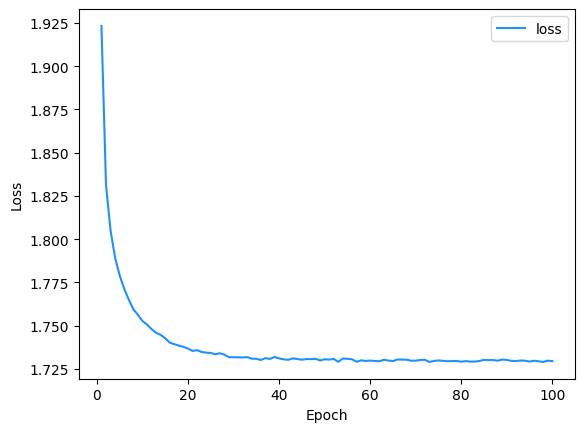

In [108]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

lr_final = 0.0001
gamma_final = 20
epoch_final = 100

model = SVM(gamma_final).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_final)

model.train()

hist_final = train(train_loader, model, CrossEntropy, optimizer, epoch_final)
plt.plot(range(1, epoch_final+1), hist_final, 'dodgerblue', label='loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig9_multi_test_loss.png', dpi=200, bbox_inches='tight')


In [111]:
# Performance for each class
classes = list(labels_map.values())
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).softmax(dim=1)
        _, predictions = torch.max(outputs, dim=1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                correct += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:10s} is {accuracy:.2f}% ({correct_count:3}/{total_pred[classname]})')

print()
print(f"Total Accuracy : {100 * correct / len(testset):.2f}% ({correct}/{len(testset)})")

Accuracy for class: airplane   is 49.00% (490/1000)
Accuracy for class: automobile is 48.10% (481/1000)
Accuracy for class: bird       is 26.00% (260/1000)
Accuracy for class: cat        is 27.50% (275/1000)
Accuracy for class: deer       is 33.10% (331/1000)
Accuracy for class: dog        is 33.90% (339/1000)
Accuracy for class: frog       is 49.60% (496/1000)
Accuracy for class: horse      is 45.30% (453/1000)
Accuracy for class: ship       is 52.00% (520/1000)
Accuracy for class: truck      is 49.40% (494/1000)

Total Accuracy : 41.39% (4139/10000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


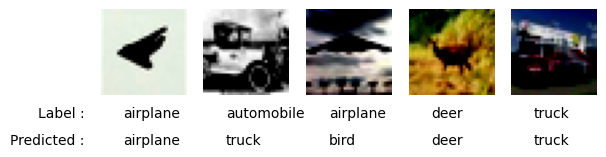

In [112]:
# Predict several data
pick_data = np.random.choice(len(test_loader), 5, replace=False)
for i in range(5):
    plt.subplot(1,5,i+1)
    
    if i == 0:
        plt.text(-5, 40, "Label : ", horizontalalignment='right')
        plt.text(-5, 50, "Predicted : ", horizontalalignment='right')

    data = testset[pick_data[i]]
    img = data[0]
    label = data[1]
    pred = predict(img, model).item()
    
    plt.imshow(img.permute(1,2,0))
    plt.text(8,40,labels_map[label])
    plt.text(8,50,labels_map[pred])
    plt.axis('off')

plt.savefig('plot/fig10_multi_test_predict.png', dpi=200, bbox_inches='tight')